# Hospitalizations by State

- comments: false
- author: Ryan Gomez
- toc: true
- categories: [growth, compare, hospitalizations]
- image: images/covid-compare-country-death-hos.png
- permalink: /futureproof-COVID19-us-hosp/

In [1]:
# Imports
import os
import pandas as pd
import csv
import kaggle

# other imports
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from copy import copy
import seaborn as sns
from scipy.stats import norm
import matplotlib.dates as mdates
# import matplotlib.colors as mcolors
# import random
# import math
# import time
# from sklearn.linear_model import LinearRegression, BayesianRidge
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
# from sklearn.svm import SVR
from datetime import date, datetime
from dateutil.parser import parse
import us
# import operator 
# plt.style.use('fivethirtyeight')
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline 

c:\programdata\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Covid Tracking Dataset (w/ hospitalised data)

Source: https://covidtracking.com/

## Load and Clean the Data

In [2]:
all_cases = pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv')

# Delete unecessary rows
for row in ['negative', 'pending', 'hash', 'negativeIncrease', 'totalTestResults', 'totalTestResultsIncrease', 'dateChecked', 'fips', 'inIcuCumulative', 'onVentilatorCumulative', 'total', 'posNeg', 'deathIncrease', 'hospitalizedIncrease', 'positiveIncrease']:
    del all_cases[row]

# TODO missing values
#      Do we get avg or missing values, or predict them?
#      See https://developerzen.com/data-mining-handling-missing-values-the-database-bd2241882e72

for i, row in all_cases.iterrows():
    # Set Dates
    s = str(row['date'])
    all_cases.at[i, 'date'] = date(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8]))

# Missing death figures means no death reports yet
# These are set to 0
for i, row in all_cases.iterrows():
    if np.isnan(row['death']):
        all_cases.at[i, 'death'] = 0

## Missing values: Retrieving from other datasets or through merging columns (or both)

The following will be done:
- **Active Cases**: Retrieved from JHU dataset and calculating $active = pos-dead-recovered$
- **Beds per State**: Retrieved from External Datasets

In [3]:
# TODO Replace active cases with JHU and/or regression model (Selma)
all_cases['active'] = all_cases['positive'] - all_cases['recovered'] - all_cases['death']
# change location of 'active' column
cols = list(all_cases)
cols.insert(3, cols.pop(cols.index('active')))
all_cases = all_cases.loc[:, cols]

In [4]:
# Load datasets for US population and Hospital beds per 1000
us_population = pd.read_csv('data/us_population.csv')
hosp_beds = pd.read_csv('data/hospital_beds.csv')
state_abbrev = pd.read_csv('data/us_state_names.csv')

# add state abbreviations to us_population and hospital beds dataframe
for state in state_abbrev['State'].tolist():
    # store state abbreviation in variable
    abbrev = state_abbrev.loc[state_abbrev['State'] == state, 'Abbreviation'].tolist()[0]
    # add abbrev to new column 'Abbreviation' in us_population df
    us_population.loc[us_population['State'] == state, 'Abbreviation'] = abbrev
    # add abbrev to new column in hosp_beds df
    hosp_beds.loc[hosp_beds['Location'] == state, 'Abbreviation'] = abbrev
    
# change order of columns of us_population
cols = list(us_population)
cols.insert(2, cols.pop(cols.index('Abbreviation')))
us_population = us_population.loc[:, cols]

# drop unnecessary columns of us_population
us_population = us_population.drop(columns=['rank', 'Growth', 'Pop2018', 'Pop2010', 'growthSince2010', 'Percent', 'density'])

# drop unnecessary columns of hosp_beds
hosp_beds = hosp_beds.drop(columns=['Location', 'State/Local Government', 'Non-Profit', 'For-Profit'])

# change order of columns of hosp_beds
cols = list(hosp_beds)
cols.insert(0, cols.pop(cols.index('Abbreviation')))
hosp_beds = hosp_beds.loc[:, cols]

In [5]:
us_population.head()

,State,Abbreviation,Pop
0,Alabama,AL,4908621
1,Alaska,AK,734002
2,Arizona,AZ,7378494
3,Arkansas,AR,3038999
4,California,CA,39937489


In [6]:
hosp_beds.head()

,Abbreviation,Total
0,NaN,2.4
1,AL,3.1
2,AK,2.2
3,AZ,1.9
4,AR,3.2


In [7]:
# filter out non-existing states like 'AS'
all_cases = all_cases[all_cases['state'].isin(state_abbrev['Abbreviation'].tolist())]

In [8]:
# see what filtered dataframe looks like
all_cases.head()

,date,state,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,dataQualityGrade,...,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,2020-06-28,AK,883.0,348.0,12.0,NaN,NaN,1.0,521.0,A,...,108300.0,NaN,NaN,NaN,0,0,0,0,0,NaN
1,2020-06-28,AL,35441.0,15656.0,655.0,2703.0,NaN,NaN,18866.0,B,...,NaN,NaN,NaN,34964.0,0,0,0,0,0,NaN
2,2020-06-28,AR,19310.0,5781.0,278.0,1373.0,NaN,63.0,13270.0,A,...,NaN,NaN,NaN,19310.0,0,0,0,0,0,NaN
4,2020-06-28,AZ,73908.0,63394.0,2691.0,4617.0,666.0,475.0,8926.0,A+,...,509485.0,NaN,NaN,73497.0,0,0,0,0,0,NaN
5,2020-06-28,CA,211243.0,NaN,5956.0,NaN,1602.0,NaN,NaN,B,...,3955952.0,NaN,NaN,211243.0,0,0,0,0,0,NaN


In [9]:
# Split dataframes by date
df_split_by_date = dict(tuple(all_cases.groupby('date')))

# Split dataframes by state
df_split_by_state = dict(tuple(all_cases.groupby('state')))

In [10]:
# merge dataframes us_population and all_cases
df_merge_uspop = all_cases.merge(us_population, how='left', left_on='state', right_on='Abbreviation')
df_merge_uspop = df_merge_uspop.drop(columns=['Abbreviation'])
df_merge_uspop = df_merge_uspop.rename(columns={'Pop': 'population'})

# change location of 'population' column
cols = list(df_merge_uspop)
cols.insert(2, cols.pop(cols.index('population')))
df_merge_uspop = df_merge_uspop.loc[:, cols]

# merge dataframes hosp_beds and df_merge_uspop
df_merge_hosp = df_merge_uspop.merge(hosp_beds, how='left', left_on='state', right_on='Abbreviation')
df_merge_hosp = df_merge_hosp.drop(columns=['Abbreviation'])
all_cases = df_merge_hosp.rename(columns={'Total': 'bedsPerThousand'})

In [11]:
all_cases.head()

,date,state,population,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,...,negativeTestsViral,positiveCasesViral,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade,State,bedsPerThousand
0,2020-06-28,AK,734002,883.0,348.0,12.0,NaN,NaN,1.0,521.0,...,NaN,NaN,0,0,0,0,0,NaN,Alaska,2.2
1,2020-06-28,AL,4908621,35441.0,15656.0,655.0,2703.0,NaN,NaN,18866.0,...,NaN,34964.0,0,0,0,0,0,NaN,Alabama,3.1
2,2020-06-28,AR,3038999,19310.0,5781.0,278.0,1373.0,NaN,63.0,13270.0,...,NaN,19310.0,0,0,0,0,0,NaN,Arkansas,3.2
3,2020-06-28,AZ,7378494,73908.0,63394.0,2691.0,4617.0,666.0,475.0,8926.0,...,NaN,73497.0,0,0,0,0,0,NaN,Arizona,1.9
4,2020-06-28,CA,39937489,211243.0,NaN,5956.0,NaN,1602.0,NaN,NaN,...,NaN,211243.0,0,0,0,0,0,NaN,California,1.8


In [12]:
# Calculate the total beds, and add the column
all_cases['total_beds'] = all_cases['population'] / 1000 * all_cases['bedsPerThousand']

In [13]:
# change abbreviations to state names
all_cases = all_cases.rename(columns={'state': 'abbrev'})
all_cases = all_cases.rename(columns={'State': 'state'})

In [14]:
# change location of 'state' column
cols = list(all_cases)
cols.insert(1, cols.pop(cols.index('state')))
all_cases = all_cases.loc[:, cols]

In [15]:
all_cases.head()

,date,state,abbrev,population,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,...,negativeTestsViral,positiveCasesViral,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade,bedsPerThousand,total_beds
0,2020-06-28,Alaska,AK,734002,883.0,348.0,12.0,NaN,NaN,1.0,...,NaN,NaN,0,0,0,0,0,NaN,2.2,1614.8044
1,2020-06-28,Alabama,AL,4908621,35441.0,15656.0,655.0,2703.0,NaN,NaN,...,NaN,34964.0,0,0,0,0,0,NaN,3.1,15216.7251
2,2020-06-28,Arkansas,AR,3038999,19310.0,5781.0,278.0,1373.0,NaN,63.0,...,NaN,19310.0,0,0,0,0,0,NaN,3.2,9724.7968
3,2020-06-28,Arizona,AZ,7378494,73908.0,63394.0,2691.0,4617.0,666.0,475.0,...,NaN,73497.0,0,0,0,0,0,NaN,1.9,14019.1386
4,2020-06-28,California,CA,39937489,211243.0,NaN,5956.0,NaN,1602.0,NaN,...,NaN,211243.0,0,0,0,0,0,NaN,1.8,71887.4802


- Load and clean JHU data
- Merge JHU dataset with main dataset

In [16]:
# This cell takes some time, as it needs to connect to Kaggle Servers to retrieve data
kaggle.api.authenticate()
kaggle.api.dataset_download_files('benhamner/jhucovid19', path='./kaggle/input/jhucovid19/', unzip=True)

In [17]:
# Get Time-Series Data of cases as Pandas DataFrame
dir_jhu = './kaggle/input/jhucovid19/csse_covid_19_data/csse_covid_19_daily_reports'

df_list = []
for dirname, _, files in os.walk(dir_jhu):
    for file in files:
        if 'gitignore' not in file and 'README' not in file:
            full_dir = os.path.join(dirname, file)
            df_list.append(pd.read_csv(full_dir))
            
jhu_df = pd.concat(df_list, axis=0, ignore_index=True, sort=True)

# convert Last Update columns to datetime format
jhu_df.loc[:, 'Last Update'] = pd.to_datetime(jhu_df['Last Update']).apply(lambda x: x.date())
jhu_df.loc[:, 'Last_Update'] = pd.to_datetime(jhu_df['Last_Update']).apply(lambda x: x.date())

# Combine Last Update with Last_Update
jhu_df['LastUpdate'] = jhu_df['Last_Update'].combine_first(jhu_df['Last Update'])

# Combine Country/Region with Country_Region
jhu_df['CountryRegion'] = jhu_df['Country/Region'].combine_first(jhu_df['Country_Region'])

# Retrieve only US data
jhu_df = jhu_df[jhu_df['CountryRegion']=='US']

# Combine Province/State with Province_State
jhu_df['ProvinceState'] = jhu_df['Province/State'].combine_first(jhu_df['Province_State'])

# Drop unnecessary columns
jhu_df = jhu_df.drop(['Admin2', 'Lat', 'Latitude', 'Long_', 'Longitude', 'Combined_Key', 'Country/Region',
                      'Country_Region', 'Province/State', 'Province_State',
                      'Last Update', 'Last_Update', 'FIPS'], axis=1)

# Change column order
cols = list(jhu_df)
cols.insert(0, cols.pop(cols.index('CountryRegion')))
cols.insert(1, cols.pop(cols.index('ProvinceState')))
cols.insert(2, cols.pop(cols.index('LastUpdate')))
jhu_df = jhu_df.loc[:, cols]

# Change region to known US states
state_abbrs_dict = {}
for state in us.states.STATES:
    state_abbrs_dict[state.abbr] = state.name

def toState(input_state, mapping):
    abbreviation = input_state.rstrip()[-2:]
    try:
        return_value = mapping[abbreviation]
    except KeyError:
        return_value = input_state
    return return_value

jhu_df['ProvinceState'] = jhu_df['ProvinceState'].apply(lambda x: toState(x, state_abbrs_dict) if x != 'Washington, D.C.' else 'District of Columbia')

# Filter out unknown states
jhu_df = jhu_df[jhu_df['ProvinceState'].isin(all_cases.state.unique().tolist())]

# Merge-sum rows with same date and State
jhu_df = jhu_df.groupby(['LastUpdate', 'ProvinceState']).agg(
    {
        'Active': sum,
        'Confirmed': sum,
        'Deaths': sum,
        'Recovered': sum
    }
).reset_index()

jhu_df.tail()

,LastUpdate,ProvinceState,Active,Confirmed,Deaths,Recovered
5190,2020-06-19,Virginia,54652.0,56238.0,1586.0,0.0
5191,2020-06-19,Washington,25947.0,27192.0,1245.0,0.0
5192,2020-06-19,West Virginia,2330.0,2418.0,88.0,0.0
5193,2020-06-19,Wisconsin,23157.0,23876.0,719.0,0.0
5194,2020-06-19,Wyoming,1126.0,1144.0,18.0,0.0


In [18]:
# Now that we have the JHU dataset relatively cleaned
# we can go ahead and merge its data with our main dataset

for i, row in all_cases.iterrows():
    last_update = all_cases.at[i, 'date']
    state = all_cases.at[i, 'state']
    matching_row = jhu_df[jhu_df['ProvinceState'] == state]
    matching_row = matching_row[matching_row['LastUpdate'] == last_update].reset_index()

    if len(matching_row.values) > 0:
        #all_cases.at[i, 'positive'] = matching_row['Confirmed'].values[0]
        all_cases.at[i, 'active'] = matching_row['Active'].values[0]
        #all_cases.at[i, 'recovered'] = matching_row['Recovered'].values[0]   --- JHU was inconsistent, therefore removed
        #all_cases.at[i, 'death'] = matching_row['Deaths'].values[0]

    # Replace unknown recovery numbers with 0
    if np.isnan(row['recovered']):
        all_cases.at[i, 'recovered'] = 0

    if all_cases.at[i, 'active'] == 0 or np.isnan(row['active']):
        positive = all_cases.at[i, 'positive']
        recovered = all_cases.at[i, 'recovered']
        dead = all_cases.at[i, 'death']
        all_cases.at[i, 'active'] = positive - recovered - dead

all_cases.tail()

,date,state,abbrev,population,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,...,negativeTestsViral,positiveCasesViral,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade,bedsPerThousand,total_beds
5927,2020-01-26,Washington,WA,7797095,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,NaN,1.7,13255.0615
5928,2020-01-25,Washington,WA,7797095,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,NaN,1.7,13255.0615
5929,2020-01-24,Washington,WA,7797095,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,NaN,1.7,13255.0615
5930,2020-01-23,Washington,WA,7797095,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,NaN,1.7,13255.0615
5931,2020-01-22,Washington,WA,7797095,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,NaN,1.7,13255.0615


In [19]:
# Save formatted dataset offline in case of disaster
dataset_file = 'results/all_cases.csv'
all_cases.to_csv(dataset_file)

In [20]:
# convert date to datetime format
all_cases['date'] = pd.to_datetime(all_cases['date'])

# An Exploratory data analysis of the US dataset
# Basic triad of the dataset: validating data types and data integrity of each row


In [21]:
dataset_file = 'results/all_cases.csv'
covid_df = pd.read_csv(dataset_file, index_col=0) 
# convert date to datetime format
covid_df['date'] = pd.to_datetime(covid_df['date'])
covid_df.info()
# set float format to 3 decimals
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5932 entries, 0 to 5931
Data columns (total 29 columns):
date                      5932 non-null datetime64[ns]
state                     5932 non-null object
abbrev                    5932 non-null object
population                5932 non-null int64
positive                  5932 non-null float64
active                    5932 non-null float64
hospitalizedCurrently     3645 non-null float64
hospitalizedCumulative    3234 non-null float64
inIcuCurrently            1883 non-null float64
onVentilatorCurrently     1675 non-null float64
recovered                 5932 non-null float64
dataQualityGrade          4998 non-null object
lastUpdateEt              5577 non-null object
dateModified              5577 non-null object
checkTimeEt               5577 non-null object
death                     5932 non-null float64
hospitalized              3234 non-null float64
totalTestsViral           1592 non-null float64
positiveTestsViral        535 

In [22]:
covid_df.head()

,date,state,abbrev,population,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,...,negativeTestsViral,positiveCasesViral,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade,bedsPerThousand,total_beds
0,2020-06-28,Alaska,AK,734002,883.000,348.000,12.000,nan,nan,1.000,...,nan,nan,0,0,0,0,0,nan,2.200,1614.804
1,2020-06-28,Alabama,AL,4908621,35441.000,15656.000,655.000,2703.000,nan,nan,...,nan,34964.000,0,0,0,0,0,nan,3.100,15216.725
2,2020-06-28,Arkansas,AR,3038999,19310.000,5781.000,278.000,1373.000,nan,63.000,...,nan,19310.000,0,0,0,0,0,nan,3.200,9724.797
3,2020-06-28,Arizona,AZ,7378494,73908.000,63394.000,2691.000,4617.000,666.000,475.000,...,nan,73497.000,0,0,0,0,0,nan,1.900,14019.139
4,2020-06-28,California,CA,39937489,211243.000,205338.000,5956.000,nan,1602.000,nan,...,nan,211243.000,0,0,0,0,0,nan,1.800,71887.480


The NaN values may indicate that there were no to few Covid-19 patients at these date points.
We further analyse the statistical values of the dataset columns to ensure data integrity and accuracy. 

In [23]:
covid_df.describe()
# TODO rounding up the numbers

,population,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,death,hospitalized,...,negativeTestsViral,positiveCasesViral,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade,bedsPerThousand,total_beds
count,5932.000,5932.000,5932.000,3645.000,3234.000,1883.000,1675.000,5932.000,5932.000,3234.000,...,535.000,3108.000,5932.000,5932.000,5932.000,5932.000,5932.000,0.000,5932.000,5932.000
mean,6542964.221,21163.612,18746.569,1023.799,4369.803,441.040,224.801,4474.004,1101.755,4369.803,...,293835.318,32231.612,0.000,0.000,0.000,0.000,0.000,nan,2.626,15806.395
std,7387050.444,46807.027,42033.173,1927.101,12949.481,692.449,328.899,11042.022,2921.727,12949.481,...,389283.058,56691.349,0.000,0.000,0.000,0.000,0.000,nan,0.744,16159.661
min,567025.000,0.000,0.000,1.000,0.000,2.000,0.000,0.000,0.000,0.000,...,17.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,1.600,1318.928
25%,1778070.000,640.000,555.000,121.000,223.000,82.000,35.500,0.000,13.000,223.000,...,50018.000,5033.000,0.000,0.000,0.000,0.000,0.000,nan,2.100,3773.952
50%,4499692.000,5122.000,4543.000,402.000,973.000,181.000,94.000,218.000,147.000,973.000,...,140972.000,13770.500,0.000,0.000,0.000,0.000,0.000,nan,2.500,11557.920
75%,7797095.000,20840.750,17541.250,1032.000,3255.250,482.000,249.000,3140.500,782.250,3255.250,...,360303.000,35463.250,0.000,0.000,0.000,0.000,0.000,nan,3.100,19124.737
max,39937489.000,392539.000,356899.000,18825.000,89995.000,5225.000,2425.000,79974.000,24835.000,89995.000,...,2070179.000,392539.000,0.000,0.000,0.000,0.000,0.000,nan,4.800,71887.480


In [24]:
# drop unnecessary columns
covid_cleaned = covid_df.drop(['hospitalized', 'bedsPerThousand'], axis=1)
covid_100k = covid_cleaned.copy()
# list of columns to transform to per 100k
columns_list = ['positive', 'active', 'recovered', 'death', 'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently', 'onVentilatorCurrently', 'total_beds']
# add columns per 100k
for column in columns_list:
    if column == 'total_beds':
        covid_100k['BedsPer100k'.format(column)] = (covid_cleaned.loc[:, column] / covid_cleaned.loc[:, 'population']) * 100000
    else:
        covid_100k['{}_100k'.format(column)] = (covid_cleaned.loc[:, column] / covid_cleaned.loc[:, 'population']) * 100000

covid_100k = covid_100k.drop(columns_list, axis=1)

In [25]:
covid_100k['date'] = pd.to_datetime(covid_100k['date'])
start_date = '2020-04-18'
end_date = '2020-05-19'
mask = (covid_100k['date'] > start_date) & (covid_100k['date'] <= end_date)
covid_100k_last_month = covid_100k.loc[mask]

In [26]:
covid_100k_last_month_part1 =  covid_100k_last_month.groupby('date').sum().loc[:, ['positive_100k','active_100k','recovered_100k','death_100k','hospitalizedCumulative_100k']].diff(periods=1, axis=0)

covid_100k_last_month_part2 = covid_100k_last_month.groupby('date').sum().loc[:, ['inIcuCurrently_100k','onVentilatorCurrently_100k','BedsPer100k']]

final_100k_last_month = covid_100k_last_month_part1.merge(covid_100k_last_month_part2, left_index=True, right_index=True)

In [27]:
final_100k_last_month.head()

,positive_100k,active_100k,recovered_100k,death_100k,hospitalizedCumulative_100k,inIcuCurrently_100k,onVentilatorCurrently_100k,BedsPer100k
date,,,,,,,,
2020-04-19,nan,nan,nan,nan,nan,153.528,80.717,13440.000
2020-04-20,413.759,391.692,35.481,25.728,22.652,156.581,79.710,13440.000
2020-04-21,387.394,360.446,65.218,30.520,31.446,166.081,78.603,13440.000
2020-04-22,428.601,989.954,412.625,28.780,36.181,167.561,78.032,13440.000
2020-04-23,452.031,-2213.482,72.921,26.282,28.842,166.277,94.521,13440.000


In [28]:
final_100k_last_month.describe()

,positive_100k,active_100k,recovered_100k,death_100k,hospitalizedCumulative_100k,inIcuCurrently_100k,onVentilatorCurrently_100k,BedsPer100k
count,30.000,30.000,30.000,30.000,30.000,31.000,31.000,31.000
mean,399.188,364.943,147.172,23.271,39.160,134.117,73.503,13440.000
std,58.939,634.169,81.341,5.781,43.524,19.860,8.141,0.000
min,287.019,-2213.482,35.481,13.315,9.507,109.602,61.622,13440.000
25%,348.980,314.204,80.563,18.439,22.991,118.222,66.261,13440.000
50%,405.026,366.234,127.774,24.119,28.295,127.613,74.706,13440.000
75%,432.647,419.664,212.491,26.201,32.754,149.768,79.157,13440.000
max,544.349,2291.210,412.625,33.917,246.371,167.561,94.521,13440.000


In [29]:
# save description cleaned dataset to csv
describe_file = 'results/final_100k_last_month.csv'
final_100k_last_month.describe().to_csv(describe_file)

## Graphical Exploratory Analysis

Plotting histograms, scatterplots and boxplots to assess the distribution of the entire US dataset. 

In [30]:
# Omitting the categorical (states/abbreviations) and time columns 
# There must be an easier way for you, but this was the easiest way I could think of
covid_cleaned['date'] = pd.to_datetime(covid_cleaned['date'])
# mask data for last month
start_date = '2020-04-18'
end_date = '2020-05-19'
mask = (covid_cleaned['date'] > start_date) & (covid_cleaned['date'] <= end_date)
covid_cleaned_last_month = covid_cleaned.loc[mask]
plot_df = covid_cleaned_last_month[['population', 'active', 'recovered', 'death', 'hospitalizedCurrently', 'inIcuCurrently', 'onVentilatorCurrently', 'total_beds']]
plot_df_last_month = covid_100k_last_month[['population', 'active_100k', 'recovered_100k', 'death_100k', 'hospitalizedCurrently_100k', 'inIcuCurrently_100k', 'onVentilatorCurrently_100k', 'BedsPer100k']]

In [31]:
timeseries_usa_df = covid_100k.loc[:, ['date', 'positive_100k', 'active_100k', 'recovered_100k', 'death_100k', 'hospitalizedCurrently_100k', 'inIcuCurrently_100k', 'onVentilatorCurrently_100k', 'BedsPer100k']].groupby('date').sum().reset_index()
# timeseries_usa_df['log_positive'] = np.log(timeseries_usa_df['positive_100k'])
# timeseries_usa_df['log_active'] = np.log(timeseries_usa_df['active_100k'])
# timeseries_usa_df['log_recovered'] = np.log(timeseries_usa_df['recovered_100k'])
# timeseries_usa_df['log_death'] = np.log(timeseries_usa_df['death_100k'])

In [32]:
timeseries_usa_df.tail()

,date,positive_100k,active_100k,recovered_100k,death_100k,hospitalizedCurrently_100k,inIcuCurrently_100k,onVentilatorCurrently_100k,BedsPer100k
154,2020-06-24,33315.285,19401.954,12359.391,1553.940,408.570,68.612,36.820,13440.000
155,2020-06-25,33812.912,19730.969,12498.864,1583.079,414.087,67.864,36.962,13440.000
156,2020-06-26,34335.924,20098.997,12643.998,1592.929,404.115,67.051,34.318,13440.000
157,2020-06-27,34829.638,20417.559,12812.241,1599.839,407.257,68.533,35.118,13440.000
158,2020-06-28,35334.565,20809.528,12921.408,1603.630,402.011,65.968,33.930,13440.000


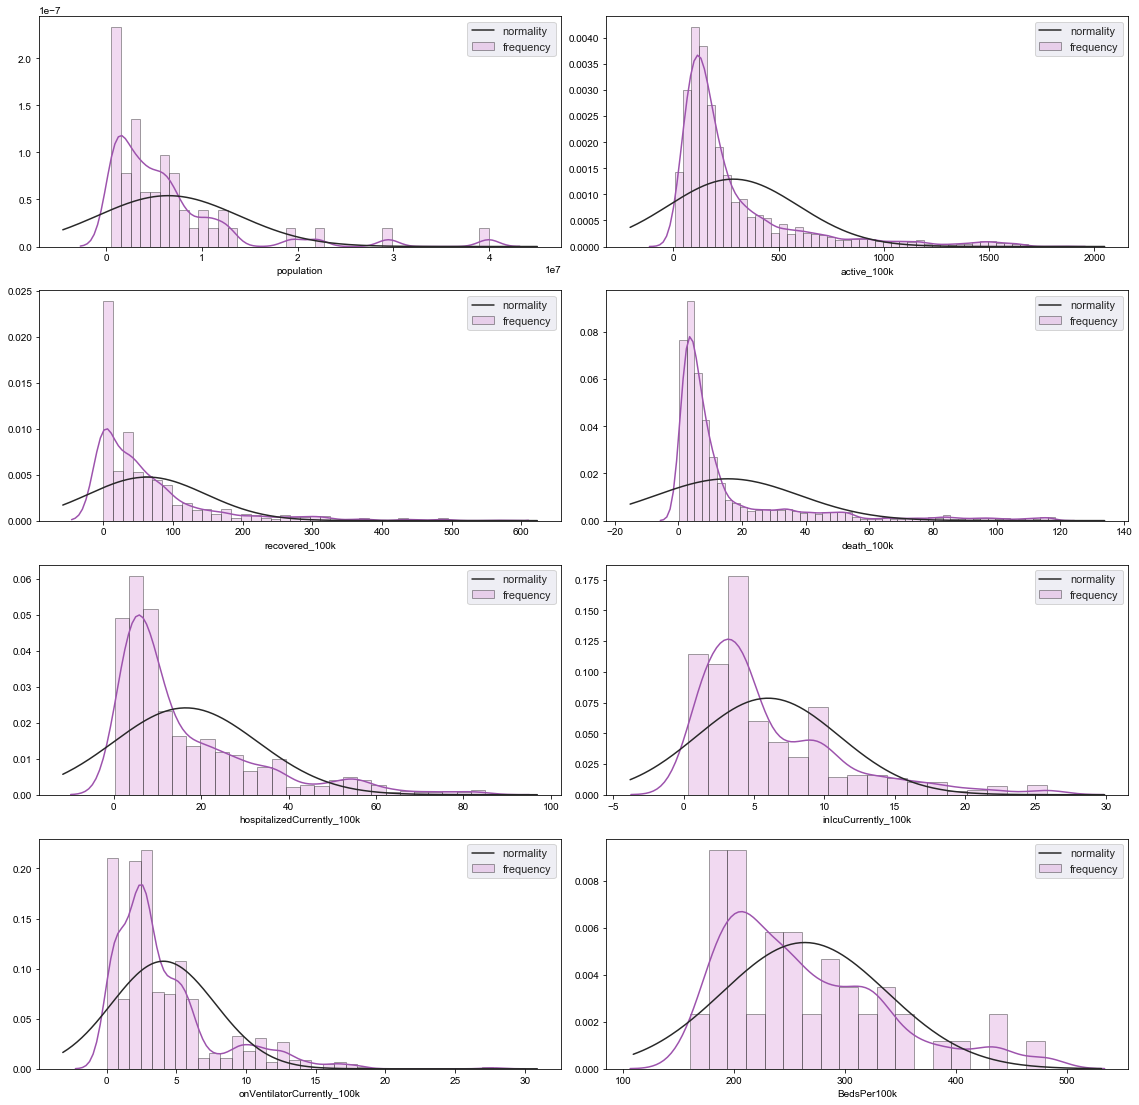

In [33]:
# get data from last day
# plot_df_last_date = plot_df.loc[covid_df['date'] == '2020-05-18'] 

# Plotting histograms to gain insight of the distribution shape, skewness and scale
fig, axs = plt.subplots(4,2,figsize = (16, 16))
sns.set()
for i, column in enumerate(plot_df_last_month.columns):
    if (i + 1) % 2 == 0:
        ax = axs[(i//2), 1]
    else:
        ax = axs[(i//2), 0]
    sns.distplot(plot_df_last_month[column], fit=norm, fit_kws=dict(label='normality'), hist_kws=dict(color='plum', edgecolor='k', linewidth=1, label='frequency'), ax=ax, color='#9d53ad')
    ax.legend(loc='upper right')
plt.tight_layout()
fig.subplots_adjust(top=0.95)

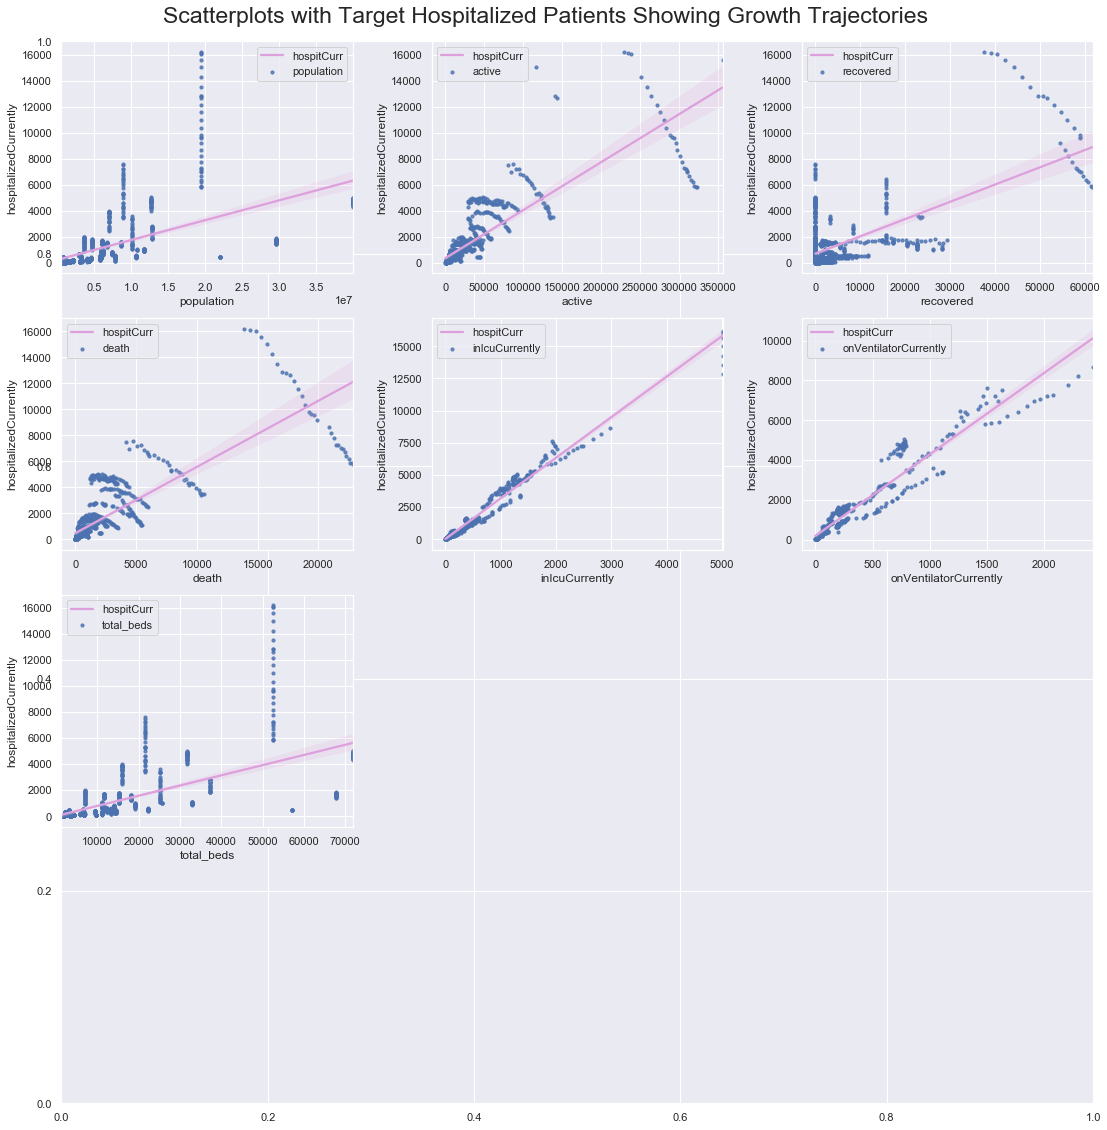

In [34]:
# Looking at linearity and variance with scatterplots
# Removing the target variable and saving it in another df
target = plot_df.hospitalizedCurrently
indep_var = plot_df.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var.columns):
    ax=fig.add_subplot(4, 3, i+1) 
    sns.regplot(x=indep_var[col], y=target, data=indep_var, label=col, scatter_kws={'s':10}, line_kws={"color": "plum", 'label': 'hospitCurr'})
    plt.suptitle('Scatterplots with Target Hospitalized Patients Showing Growth Trajectories', fontsize=23)
    plt.legend()
plt.tight_layout()
fig.subplots_adjust(top=0.95)

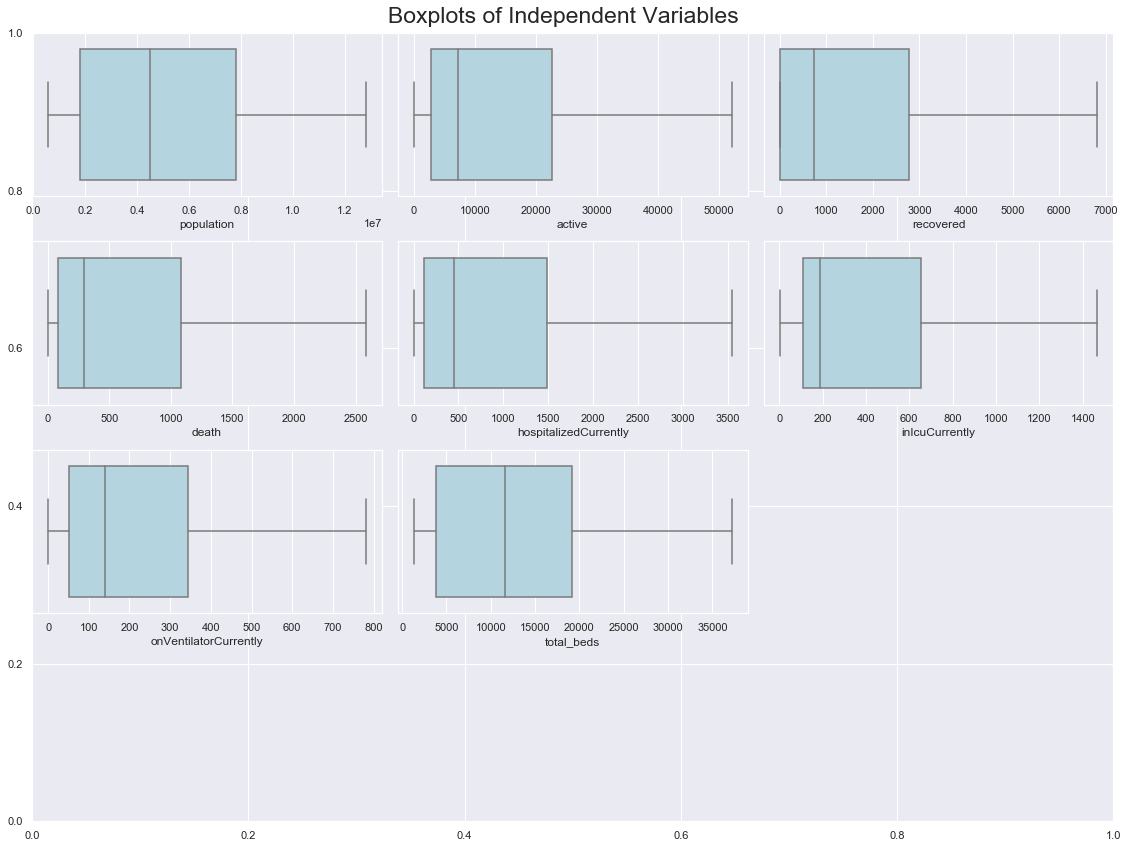

In [35]:
# Assessing the normality of the distribution with a boxplot
# Boxplot with removed outliers
fig, ax = plt.subplots(figsize = (16, 12))
for i, col in enumerate(plot_df.columns):
    ax=fig.add_subplot(4, 3, i+1) 
    sns.boxplot(x=plot_df[col], data=plot_df, color='lightblue', showfliers=False)
    plt.suptitle('Boxplots of Independent Variables', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

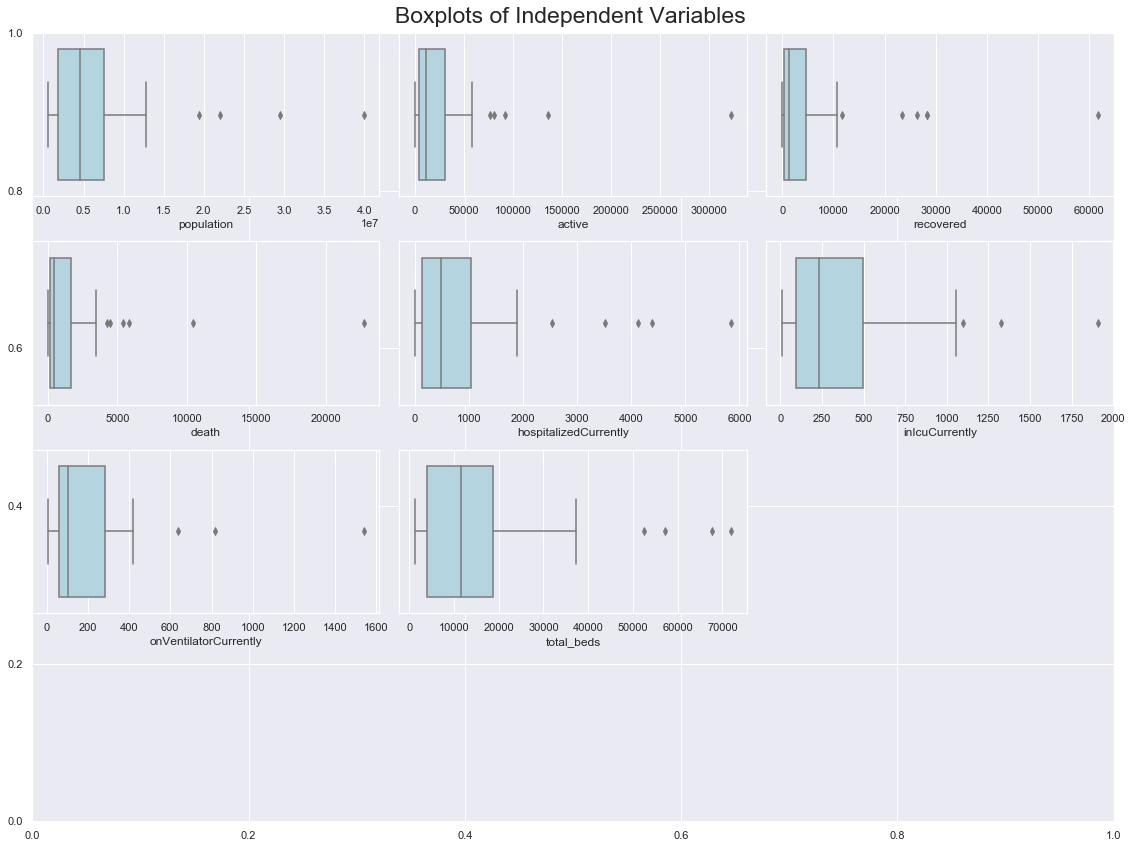

In [36]:
# get data from last day
plot_df_last_date = plot_df.loc[covid_df['date'] == '2020-05-18'] 

fig, ax = plt.subplots(figsize = (16, 12))
for i, col in enumerate(plot_df_last_date.columns):
    ax=fig.add_subplot(4, 3, i+1) 
    sns.boxplot(x=plot_df_last_date[col], data=plot_df, color='lightblue', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

## Analysis of Hospitalizations by State
### Since the normality of the independent variables is highly variable do to temporal and precision differences from each state, we further assess each state's data by viewing trends on the independent variables in both scatter and box-and-whisker plots.  


### New York:

C:\Users\Doctor Gomez\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



Text(0, 0.5, 'No. Patients')

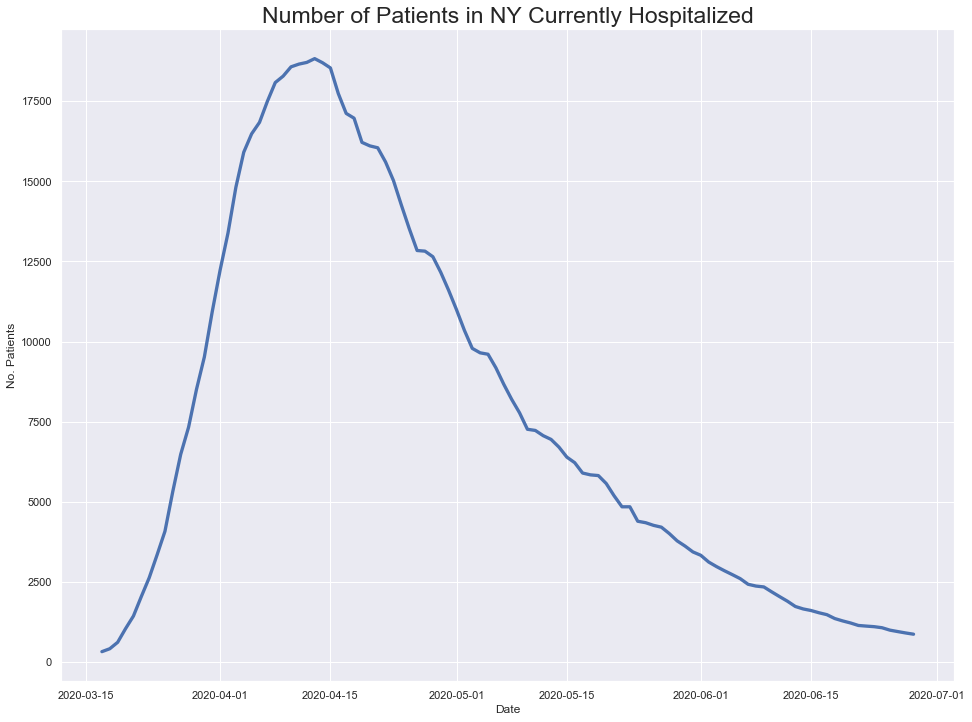

In [37]:
# Split covid_df into subset with only NY values
new_york = covid_df.loc[covid_df['abbrev'] == 'NY'] 
fig, ax = plt.subplots(figsize = (16, 12))
# Timeseries plt
plt.plot(new_york.date, new_york.hospitalizedCurrently, linewidth=3.3)
plt.title('Number of Patients in NY Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [38]:
# Omit the categorical and date cols 
new_york = new_york[['positive', 'active', 'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]

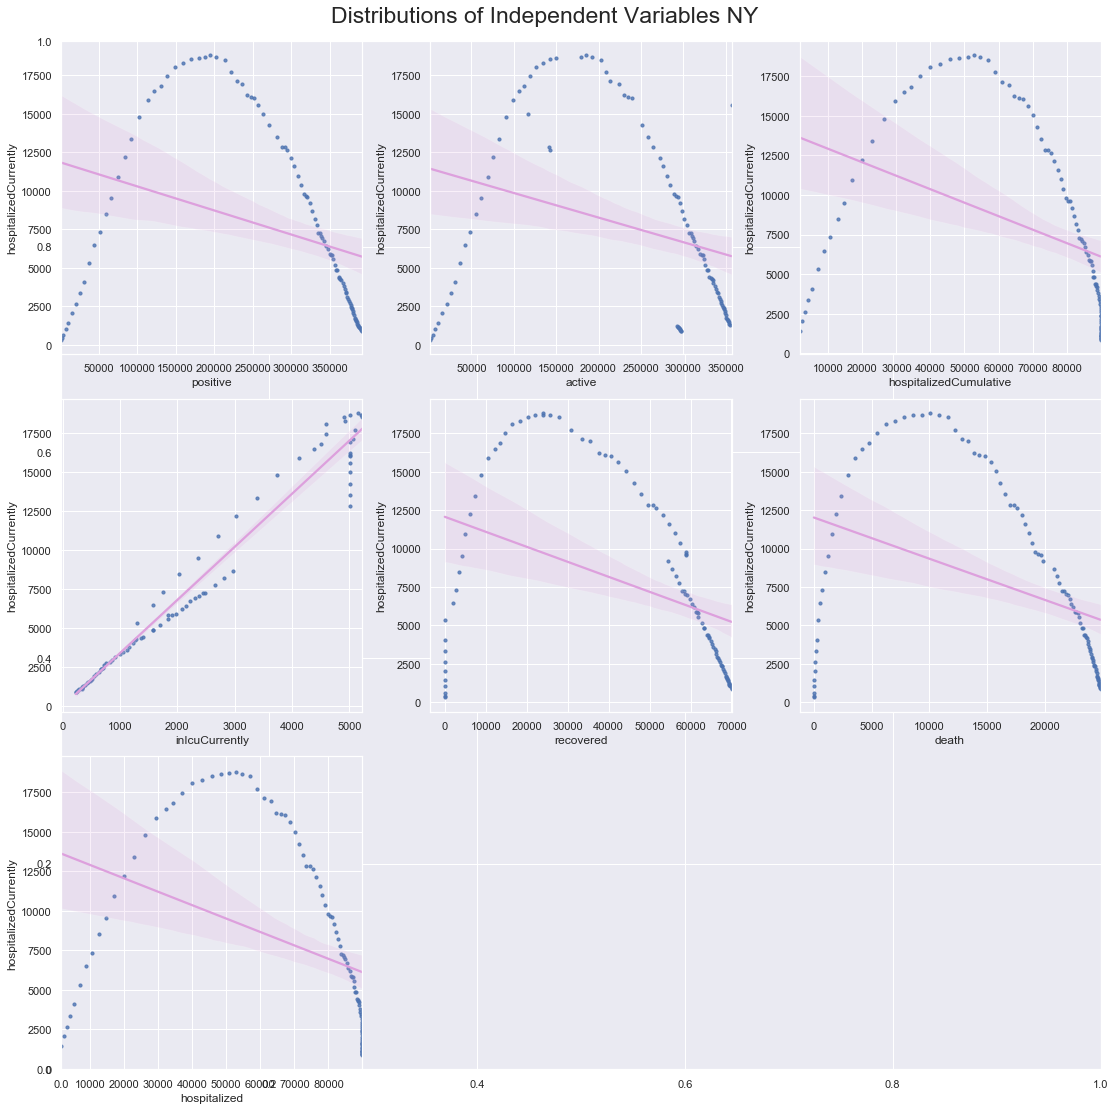

In [39]:
# Scatter plots NY
# Split dependent var from independent variables
target_ny = new_york.hospitalizedCurrently
indep_var_ny = new_york.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_ny.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.regplot(x=indep_var_ny[col], y=target_ny, data=indep_var_ny, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables NY', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)


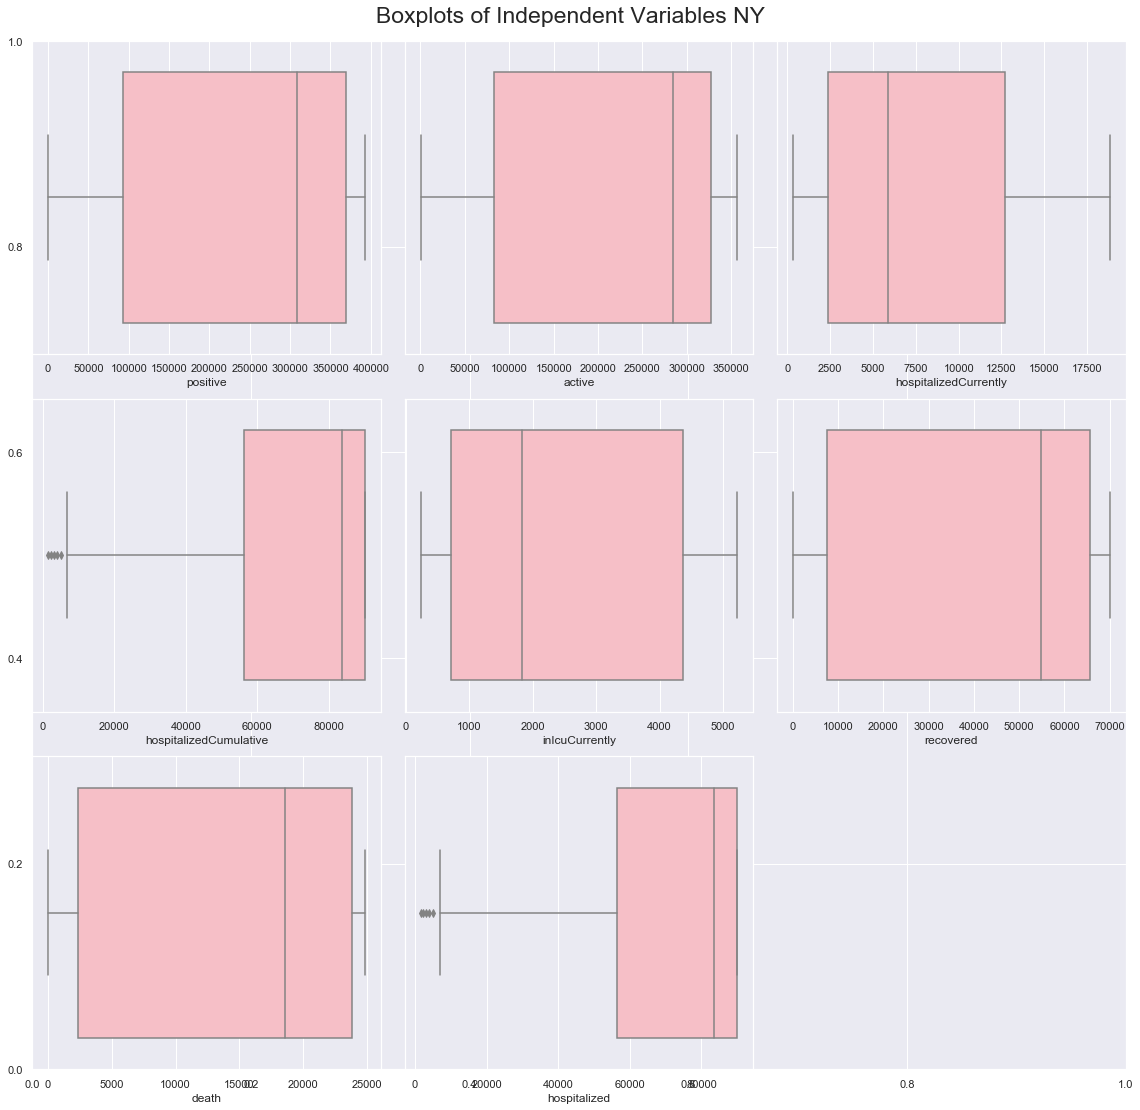

In [40]:
# Boxplot of NY
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(new_york.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=new_york[col], data=new_york, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables NY', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

### California:

In [41]:
cali = covid_df.loc[(covid_df['abbrev'] == 'CA') & (covid_df['state']== 'California')] 


Text(0, 0.5, 'No. Patients')

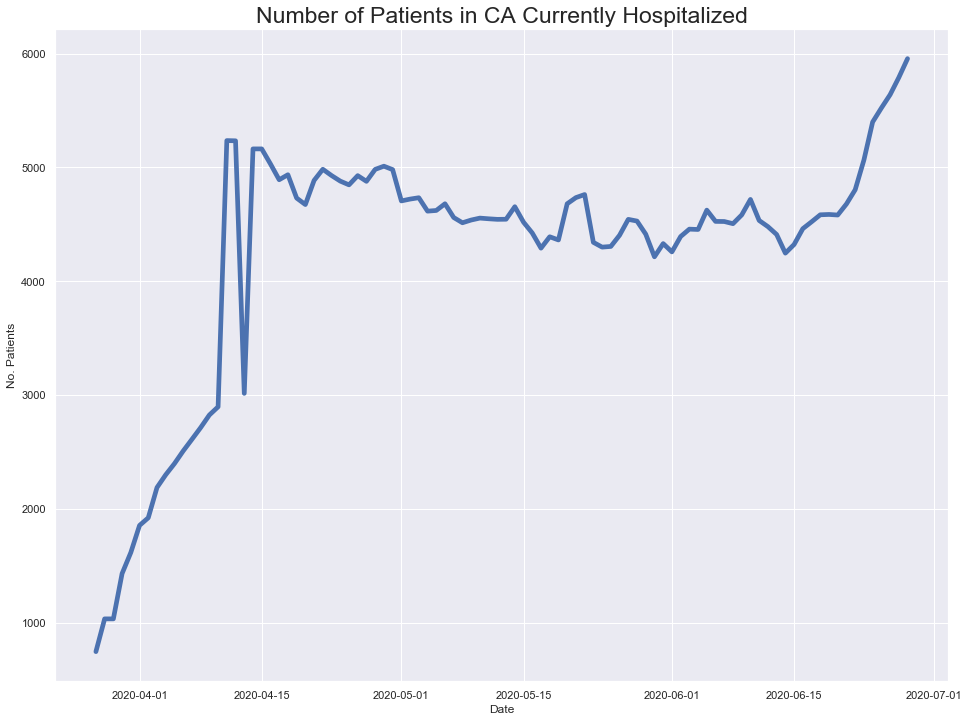

In [42]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(cali.date, cali.hospitalizedCurrently, linewidth=4.7)
plt.title('Number of Patients in CA Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [43]:
# Checking which cols have NaN values
cali[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
cali.head()

# Omit the NaN cols
cali = cali[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

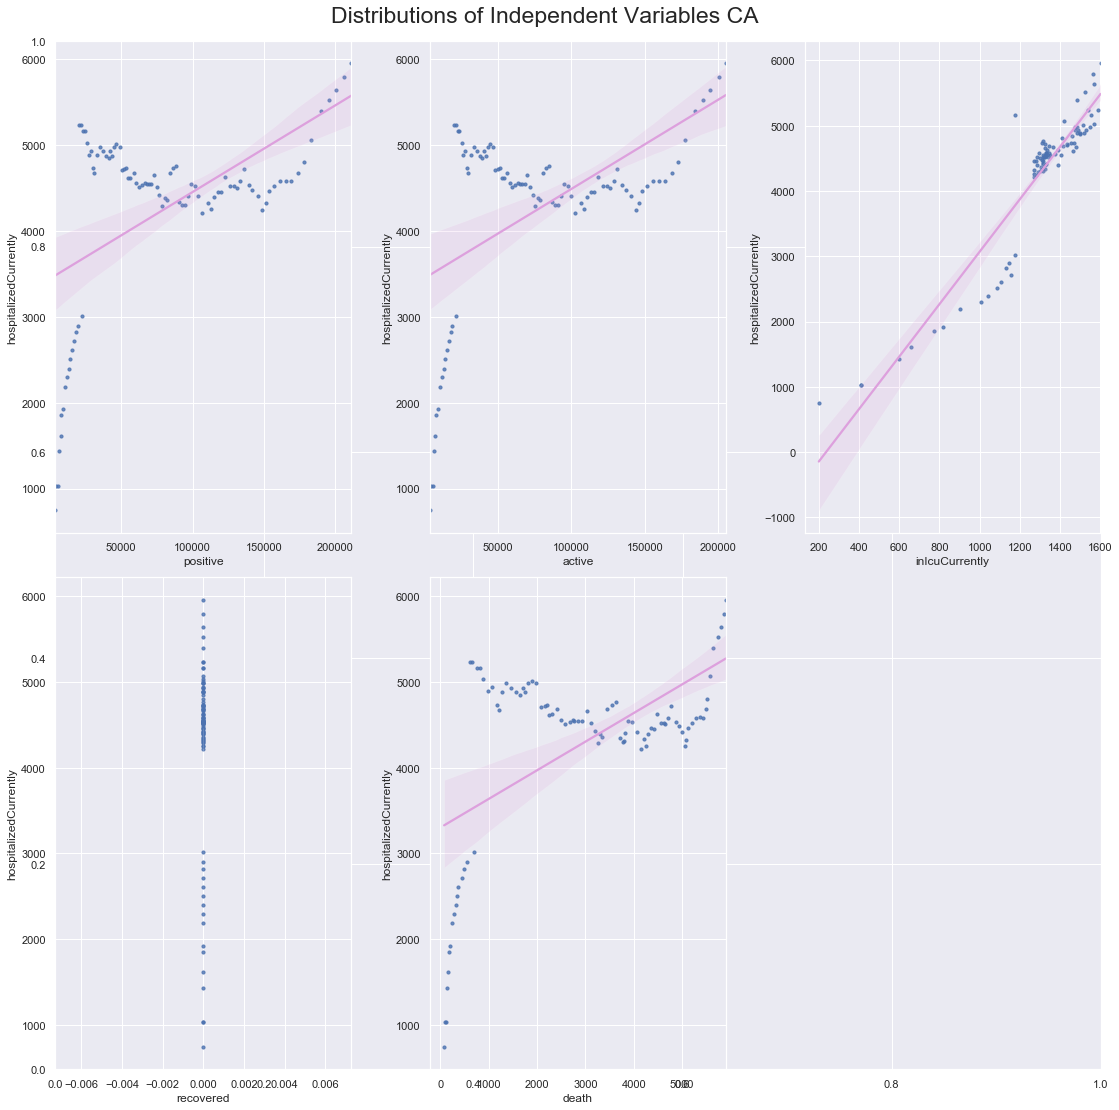

In [44]:
# Scatter plots CA
# Split dependent var from independent variables
target_ca = cali.hospitalizedCurrently
indep_var_ca = cali.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_ca.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_ca[col], y=target_ca, data=indep_var_ca, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables CA', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

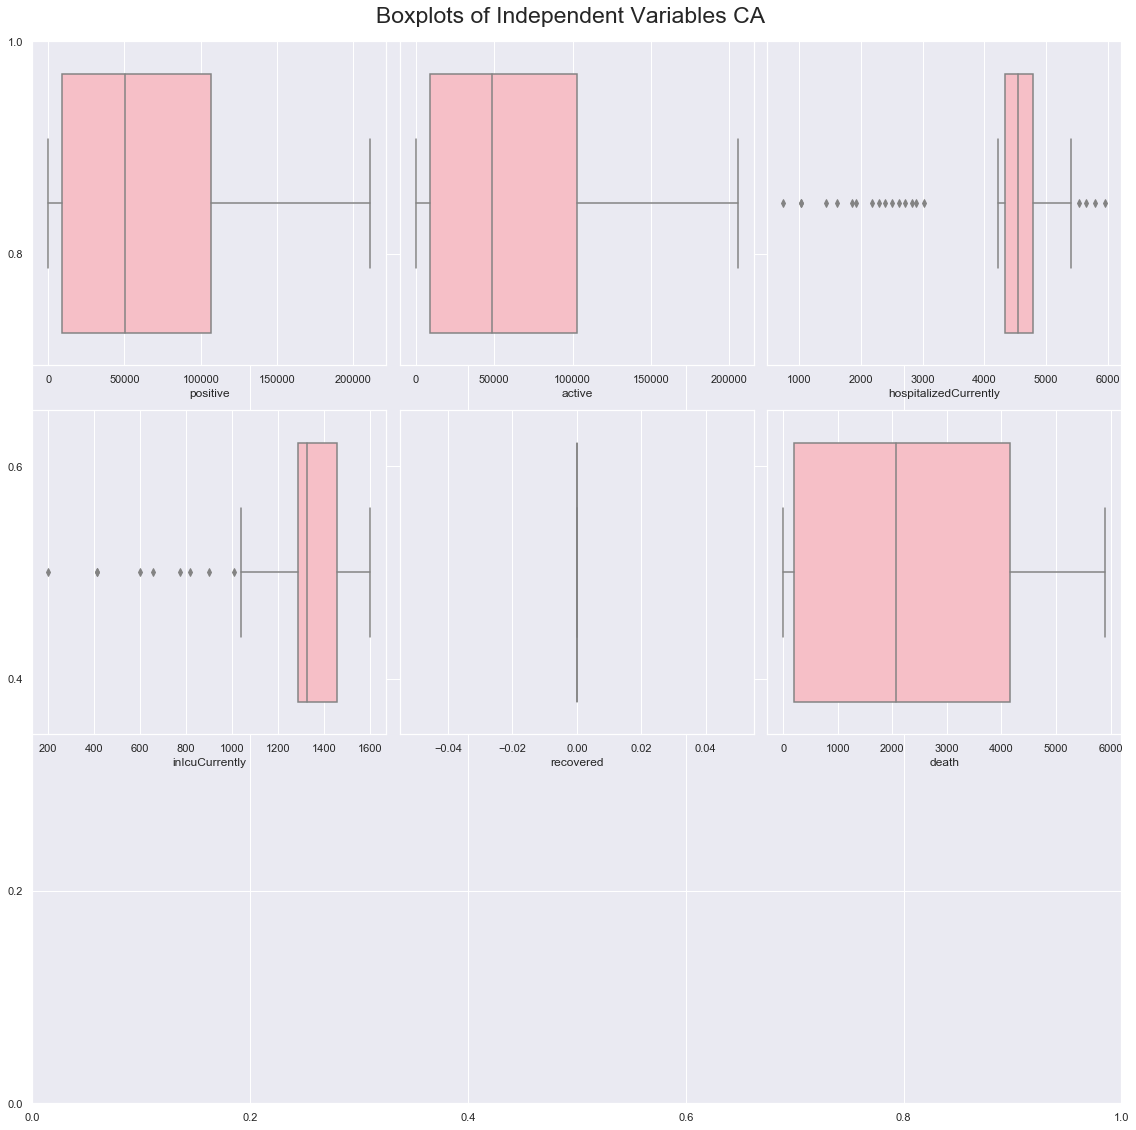

In [45]:
# Boxplot of CA
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(cali.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=cali[col], data=cali, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables CA', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [46]:
###endcali

### Texas:

In [47]:
texas = covid_df.loc[(covid_df['abbrev'] == 'TX') & (covid_df['state']== 'Texas')] 


Text(0, 0.5, 'No. Patients')

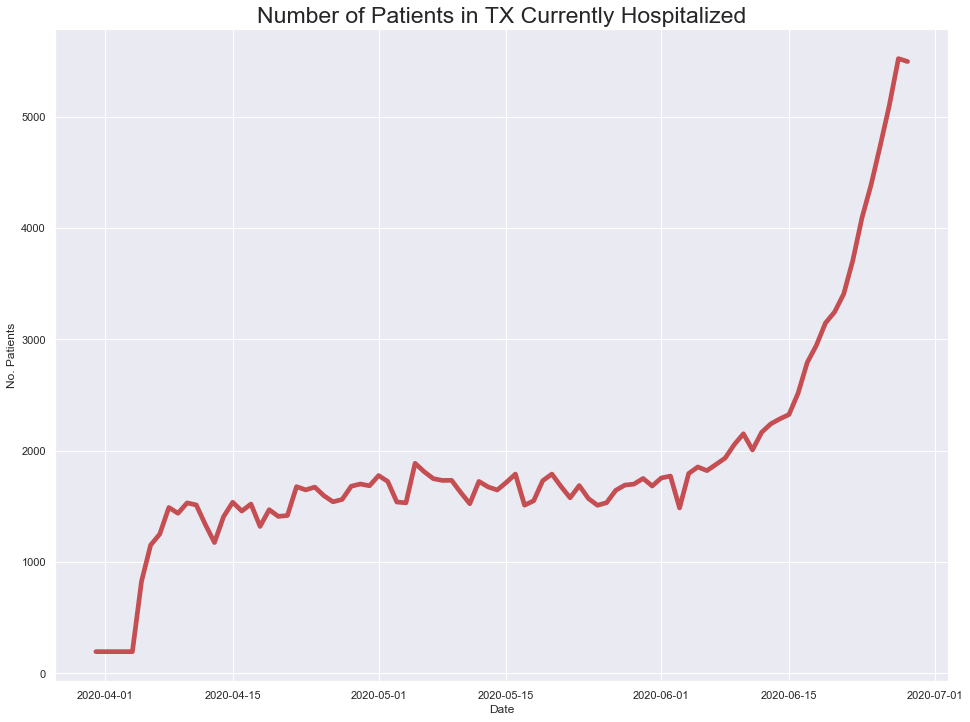

In [48]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(texas.date, texas.hospitalizedCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in TX Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

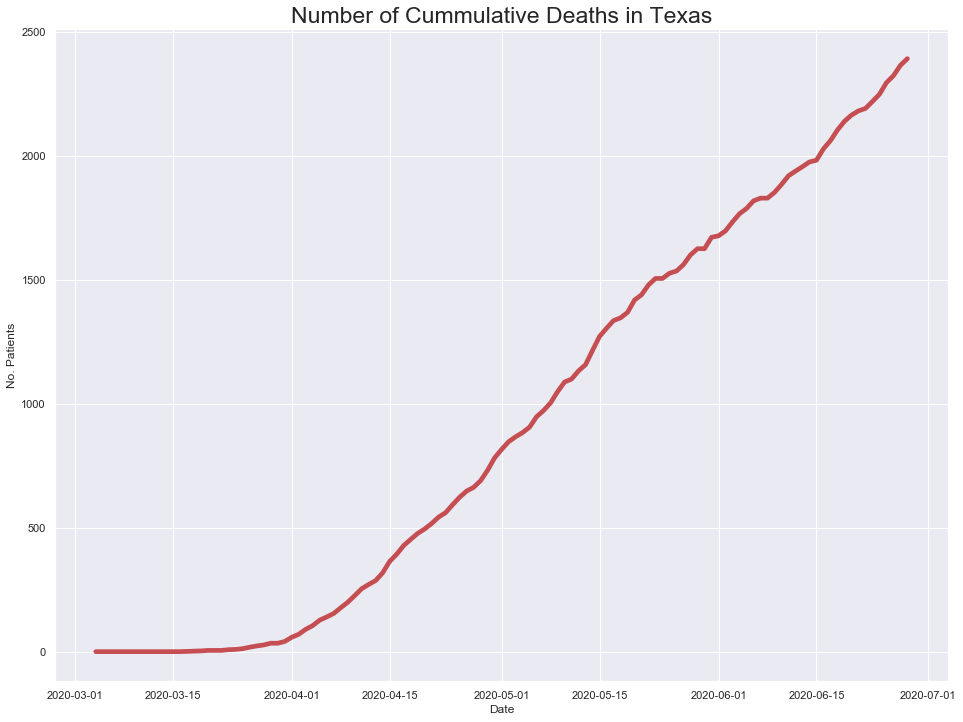

In [49]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(texas.date, texas.death, linewidth=4.7, color='r')
plt.title('Number of Cummulative Deaths in Texas', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

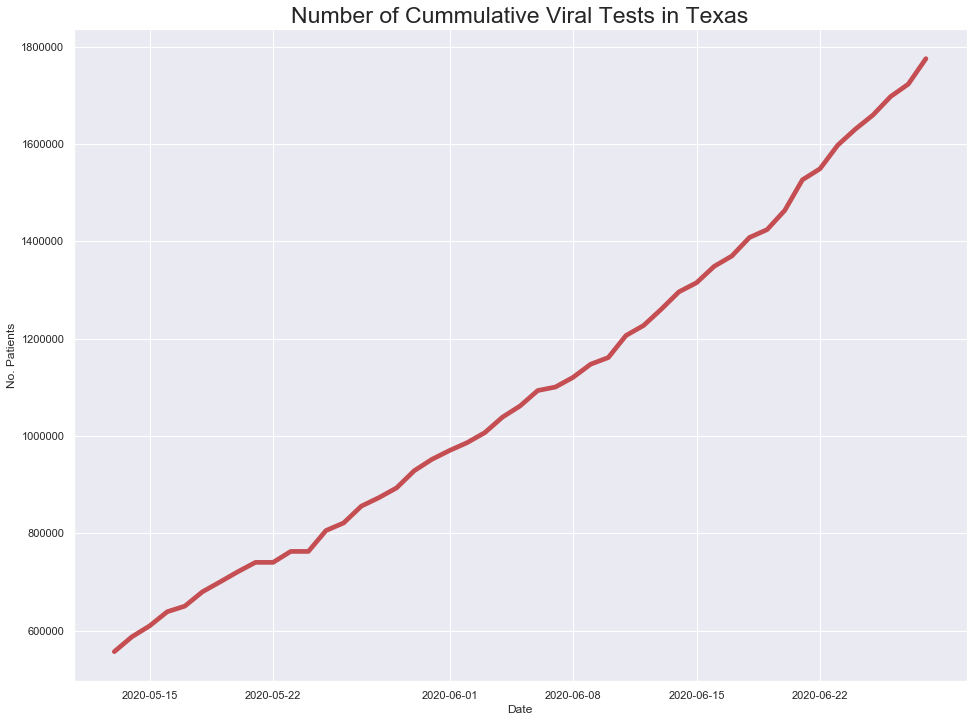

In [50]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(texas.date, texas.totalTestsViral, linewidth=4.7, color='r')
plt.title('Number of Cummulative Viral Tests in Texas', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [51]:
# Checking which cols have NaN values
texas[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
texas.head()

# Omit the NaN cols
texas = texas[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

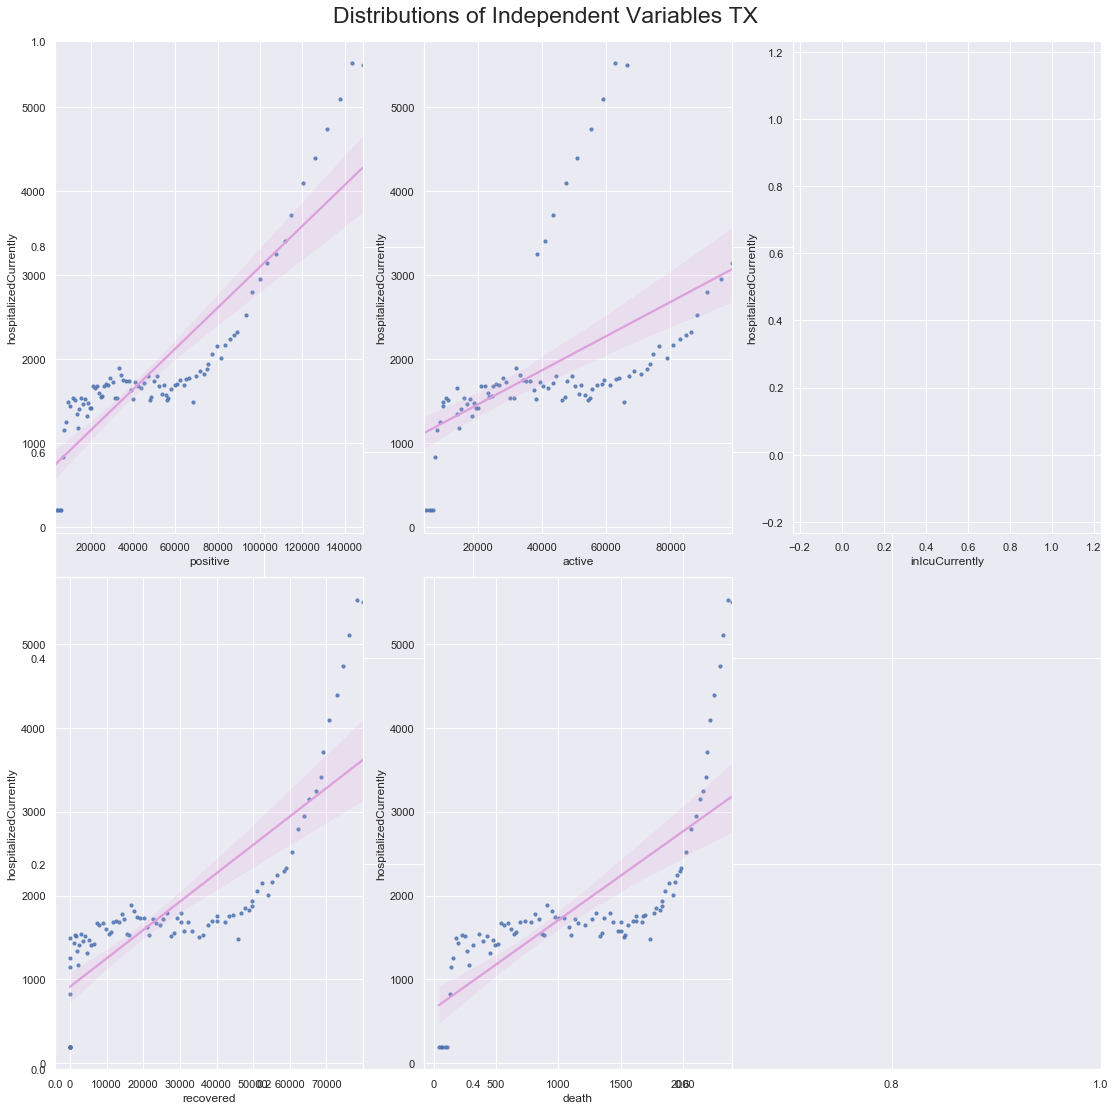

In [52]:
# Scatter plots TX
# Split dependent var from independent variables
target_tx = texas.hospitalizedCurrently
indep_var_tx = texas.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_tx.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_tx[col], y=target_tx, data=indep_var_tx, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables TX', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

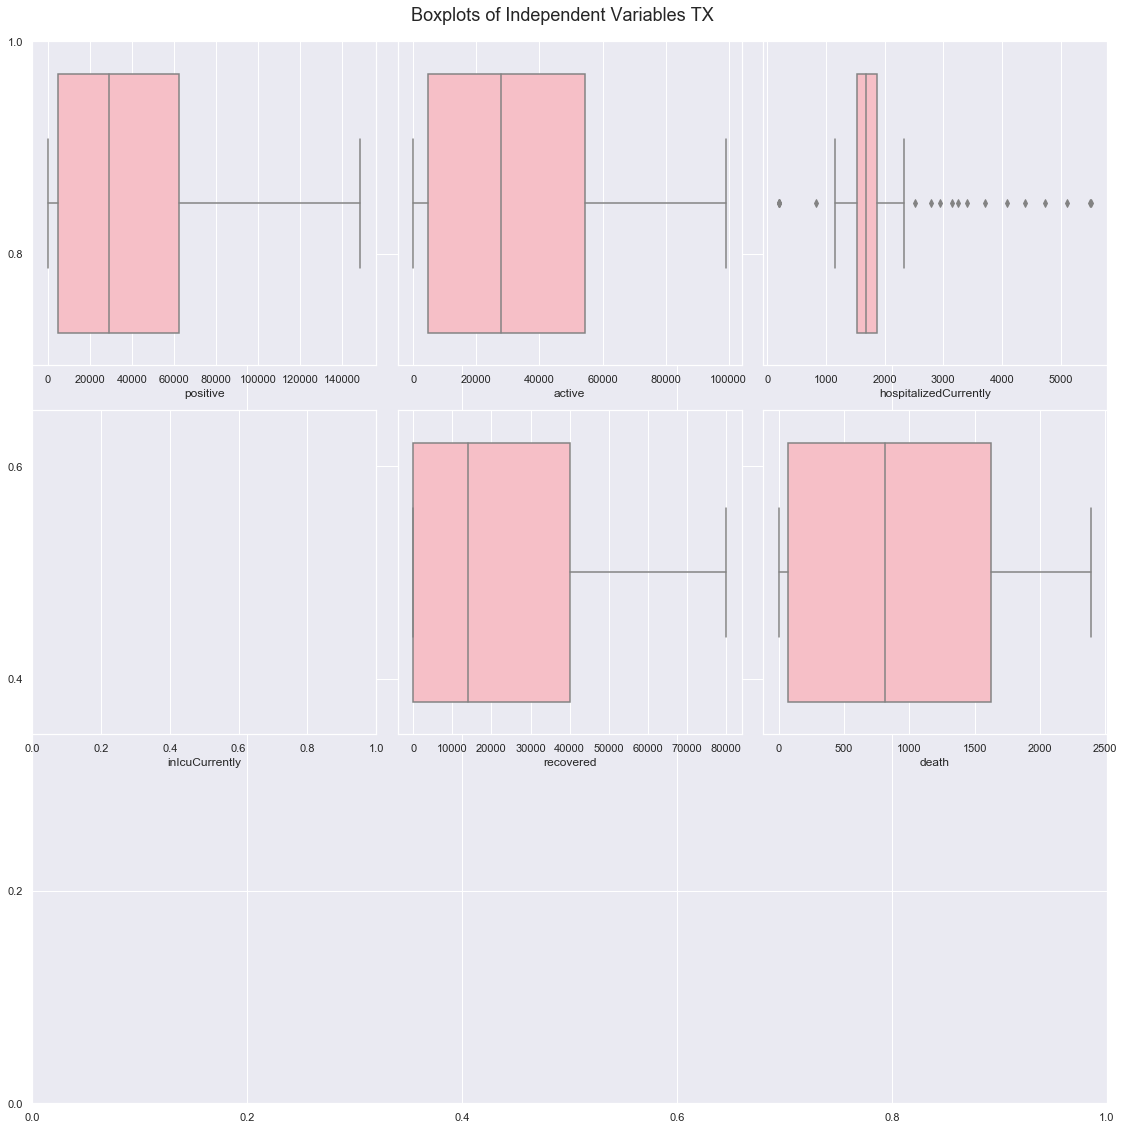

In [53]:
# Boxplot of TX
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(texas.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=texas[col], data=texas, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables TX', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [54]:
###endtx

### South Carolina:

In [55]:
sc = covid_df.loc[(covid_df['abbrev'] == 'SC') & (covid_df['state']== 'South Carolina')] 


Text(0, 0.5, 'No. Patients')

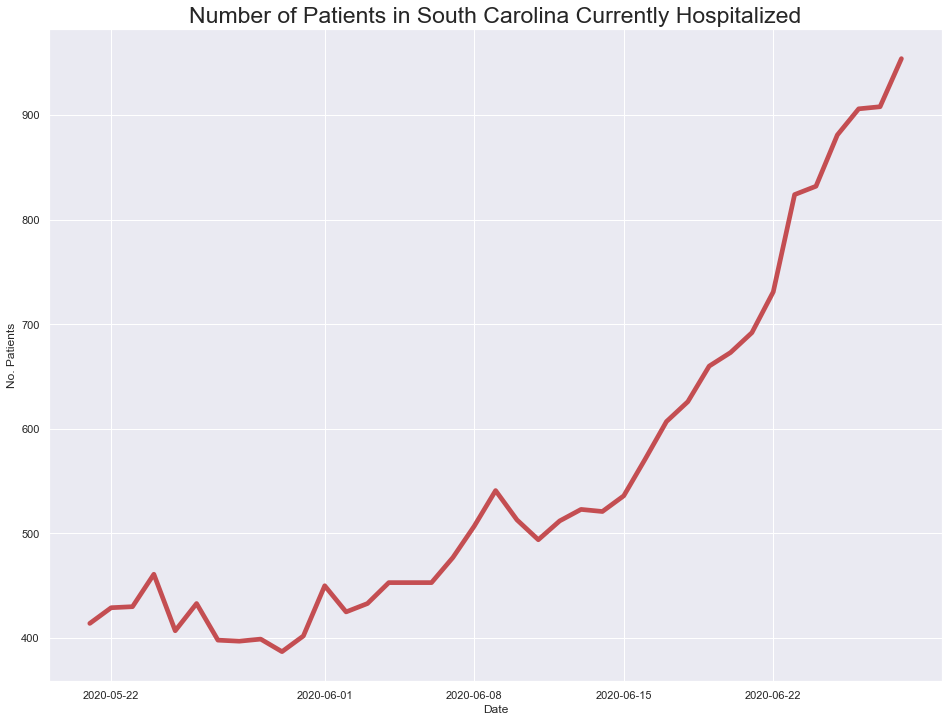

In [56]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(sc.date, sc.hospitalizedCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in South Carolina Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

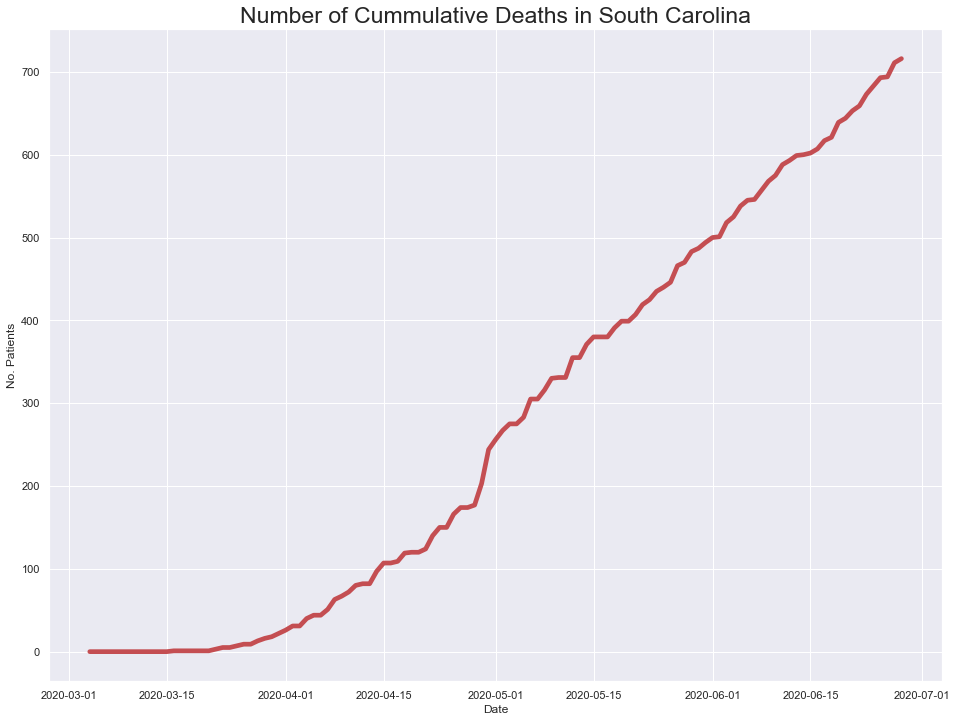

In [57]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(sc.date, sc.death, linewidth=4.7, color='r')
plt.title('Number of Cummulative Deaths in South Carolina', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

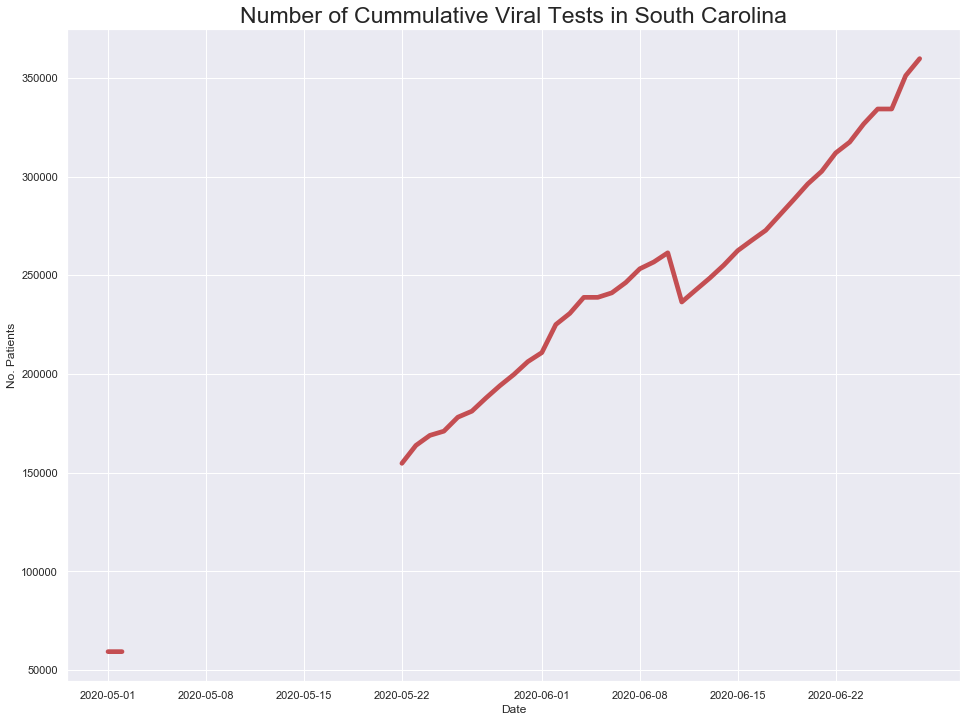

In [58]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(sc.date, sc.totalTestsViral, linewidth=4.7, color='r')
plt.title('Number of Cummulative Viral Tests in South Carolina', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

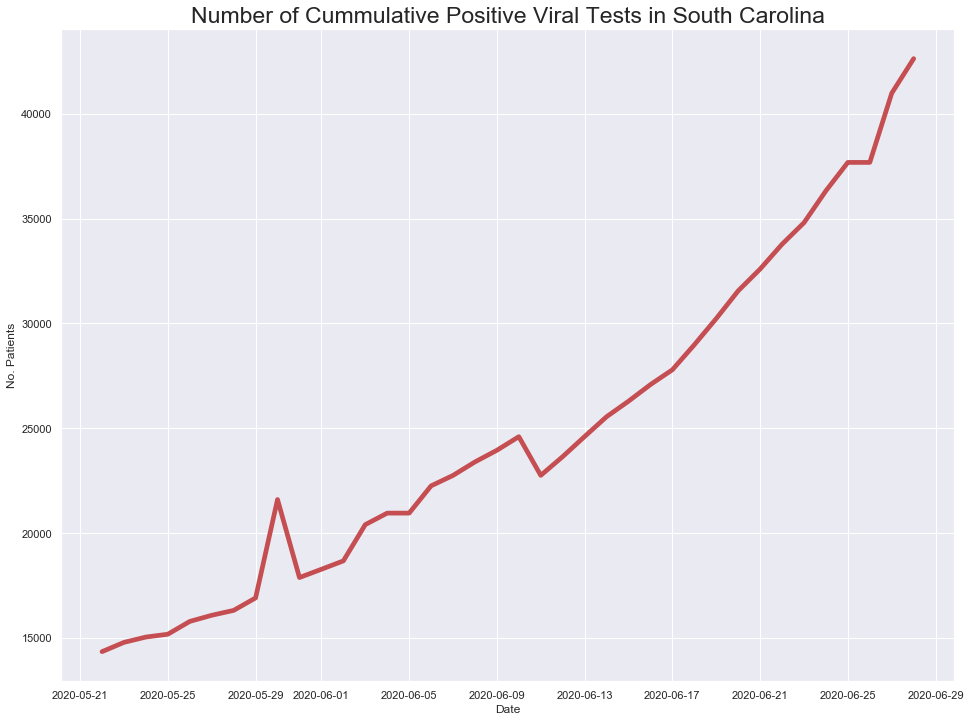

In [59]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(sc.date, sc.positiveTestsViral, linewidth=4.7, color='r')
plt.title('Number of Cummulative Positive Viral Tests in South Carolina', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, '% Infection Rate')

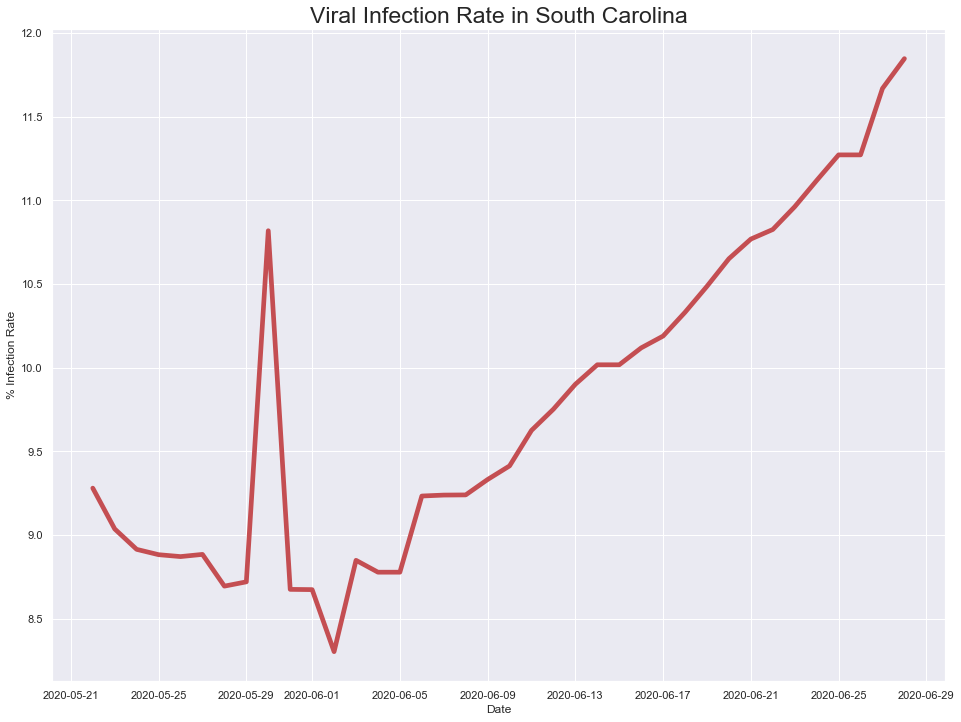

In [60]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(sc.date, sc.positiveTestsViral/sc.totalTestsViral*100, linewidth=4.7, color='r')
plt.title('Viral Infection Rate in South Carolina', fontsize=23)
plt.xlabel('Date')
plt.ylabel('% Infection Rate')

In [61]:
# Checking which cols have NaN values
sc[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
sc.head()

# Omit the NaN cols
sc = sc[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

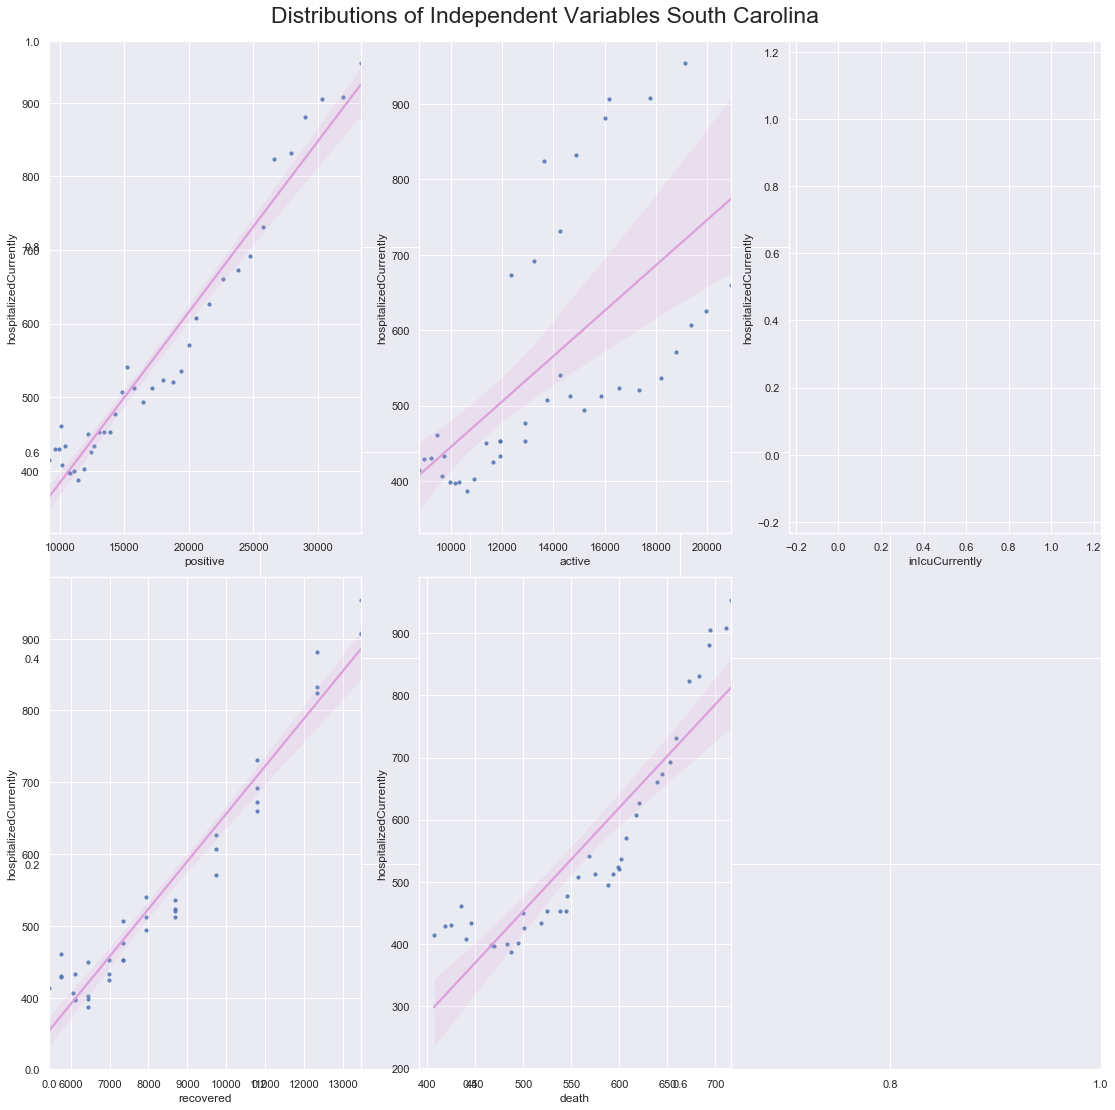

In [62]:
# Scatter plots SC
# Split dependent var from independent variables
target_sc = sc.hospitalizedCurrently
indep_var_sc = sc.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_sc.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_sc[col], y=target_sc, data=indep_var_sc, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables South Carolina', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

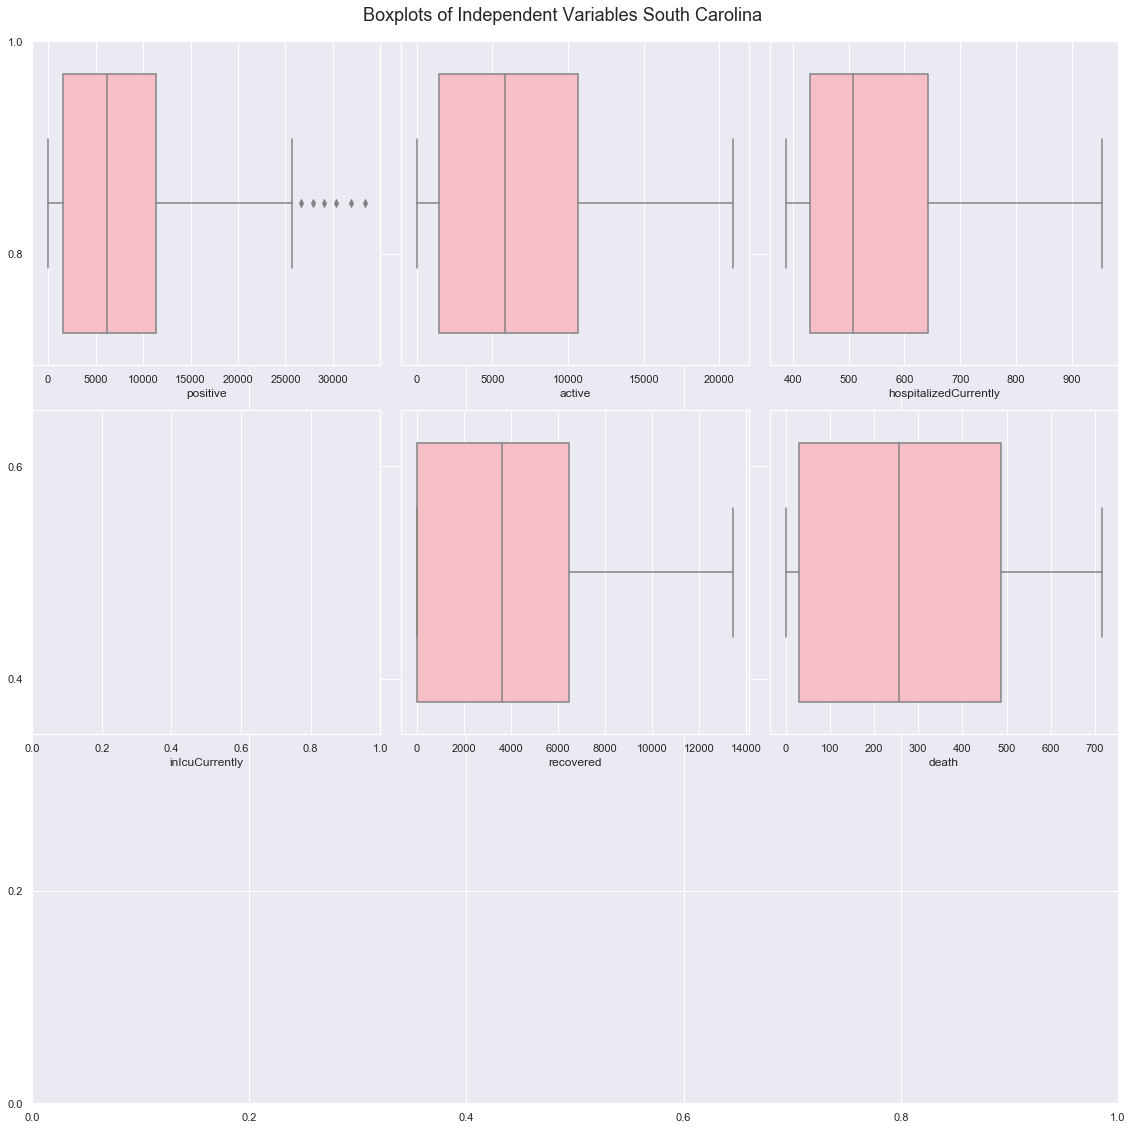

In [63]:
# Boxplot of SC
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(sc.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=sc[col], data=sc, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables South Carolina', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [64]:
###endsouthcarolina

### Nevada:

In [65]:
nevada = covid_df.loc[(covid_df['abbrev'] == 'NV') & (covid_df['state']== 'Nevada')] 


Text(0, 0.5, 'No. Patients')

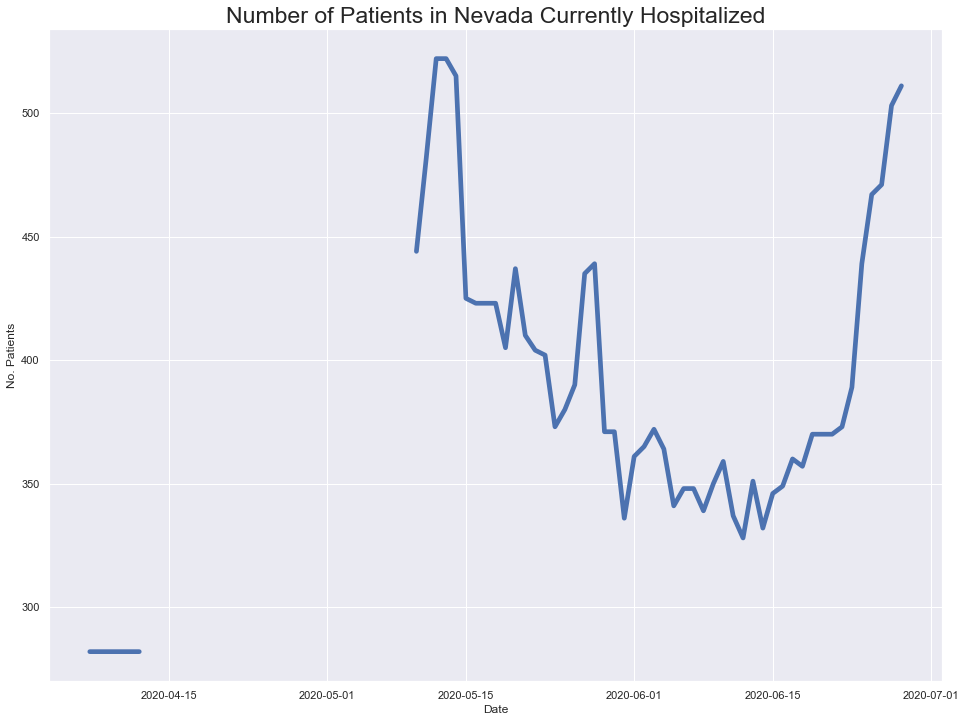

In [66]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(nevada.date, nevada.hospitalizedCurrently, linewidth=4.7)
plt.title('Number of Patients in Nevada Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

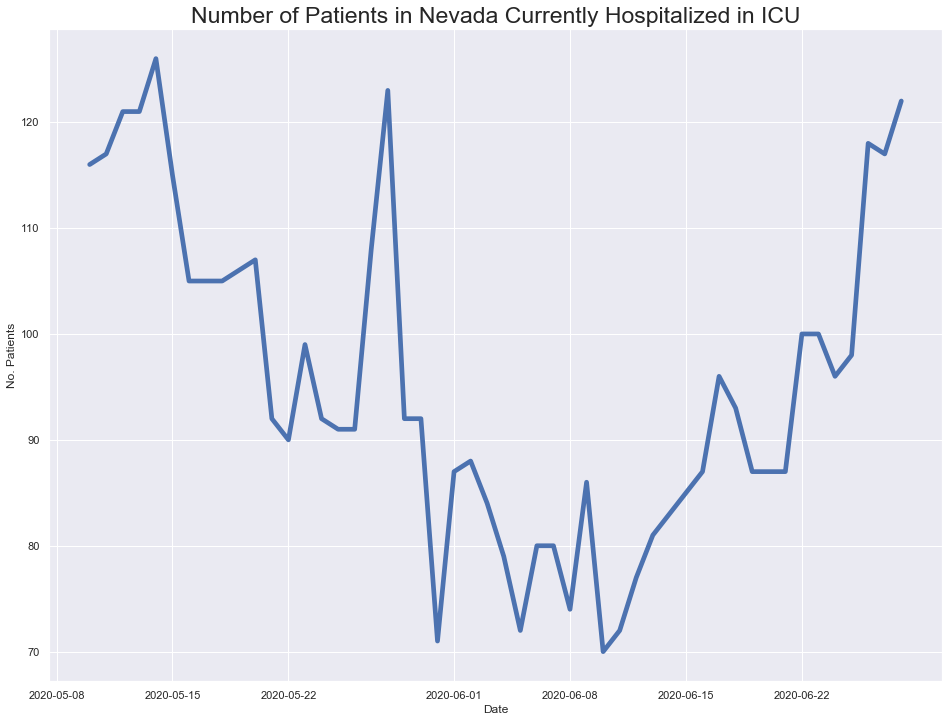

In [67]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(nevada.date, nevada.inIcuCurrently, linewidth=4.7)
plt.title('Number of Patients in Nevada Currently Hospitalized in ICU', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

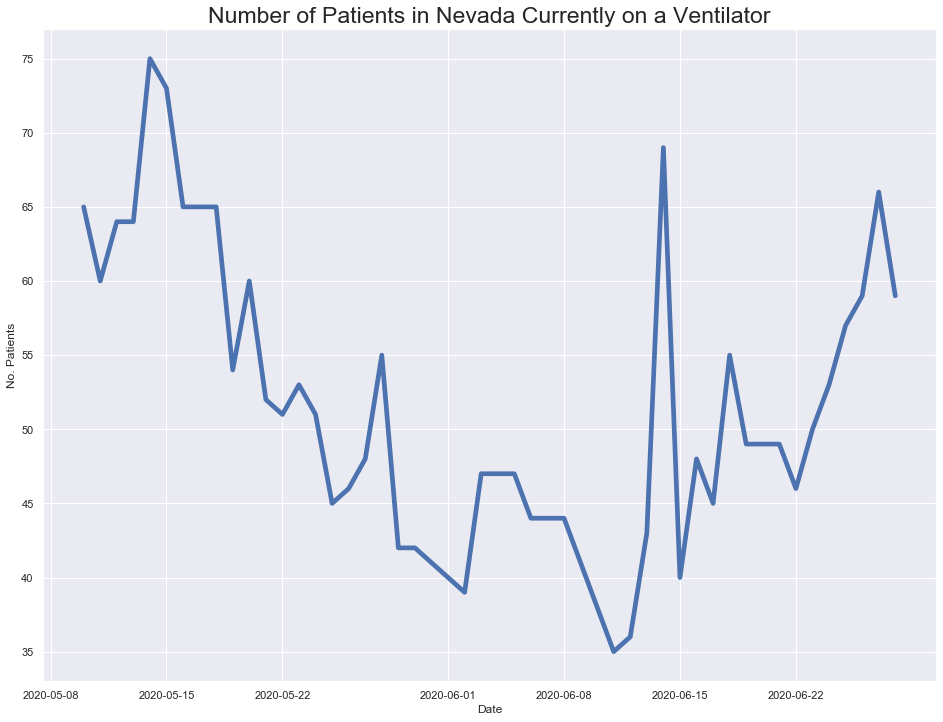

In [68]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(nevada.date, nevada.onVentilatorCurrently, linewidth=4.7)
plt.title('Number of Patients in Nevada Currently on a Ventilator', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [69]:
# Checking which cols have NaN values
nevada[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
nevada.head()

# Omit the NaN cols
nevada = nevada[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

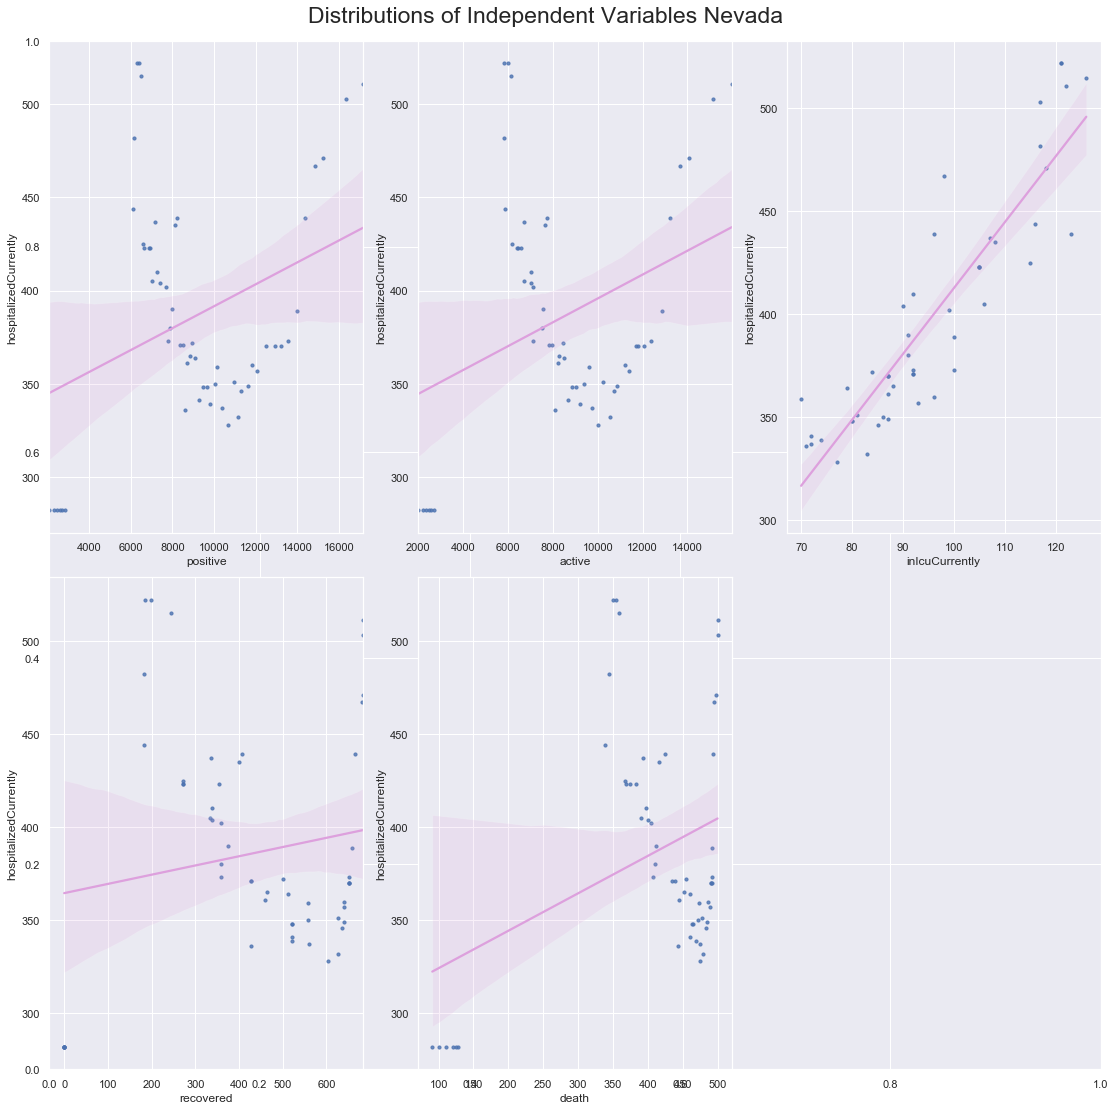

In [70]:
# Scatter plots NV
# Split dependent var from independent variables
target_nv = nevada.hospitalizedCurrently
indep_var_nv = nevada.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_nv.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_nv[col], y=target_nv, data=indep_var_nv, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables Nevada', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

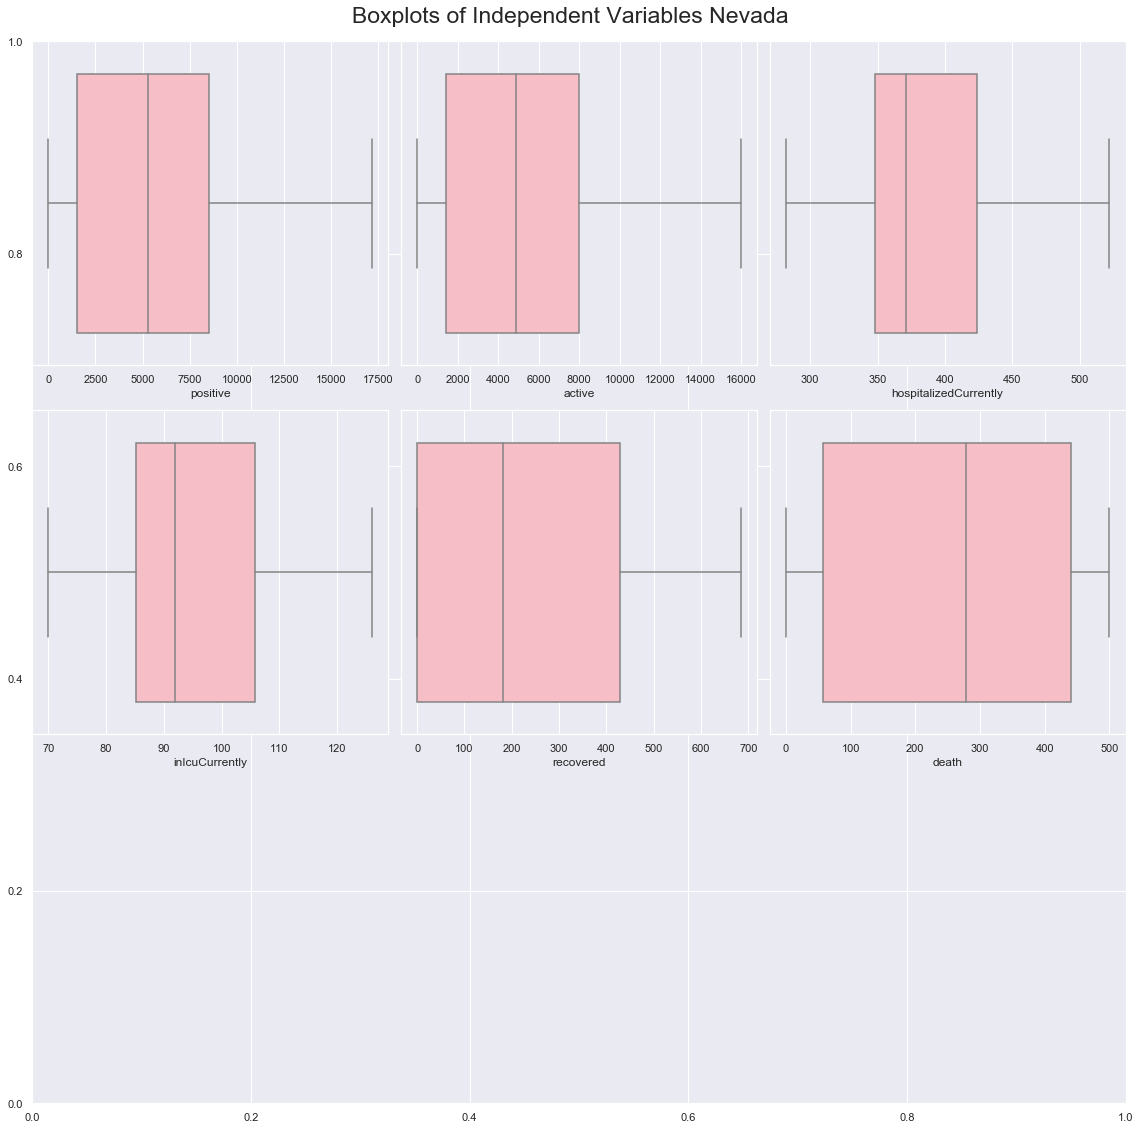

In [71]:
# Boxplot of NV
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(nevada.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=nevada[col], data=nevada, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables Nevada', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [99]:
###endnevada

### Arizona:

In [100]:
arizona = covid_df.loc[(covid_df['abbrev'] == 'AZ') & (covid_df['state']== 'Arizona')] 


Text(0, 0.5, 'No. Patients')

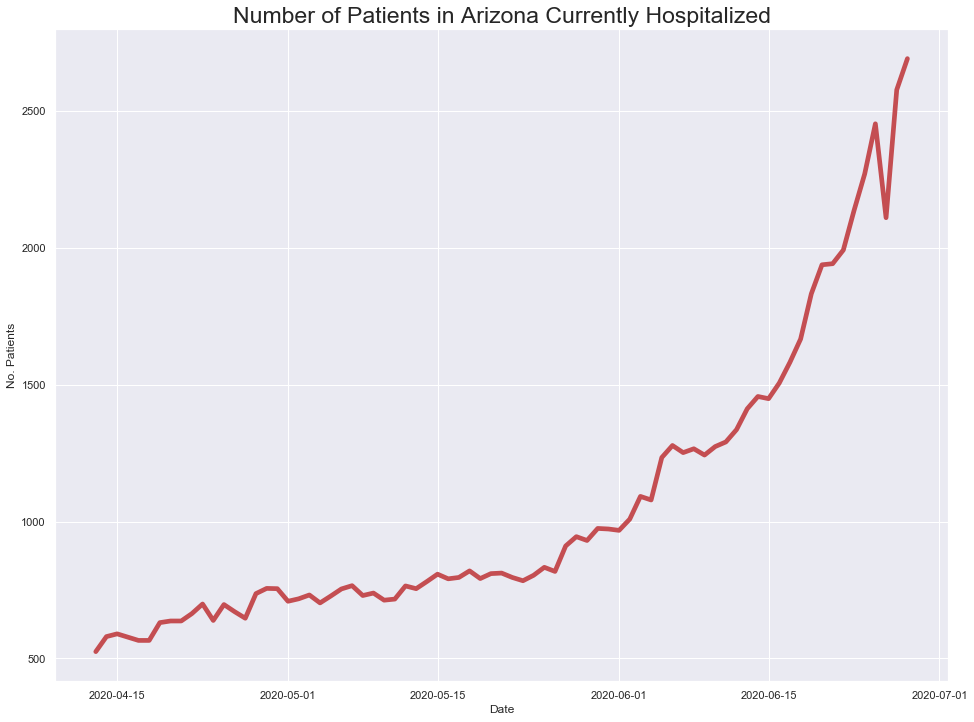

In [101]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(arizona.date, arizona.hospitalizedCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Arizona Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

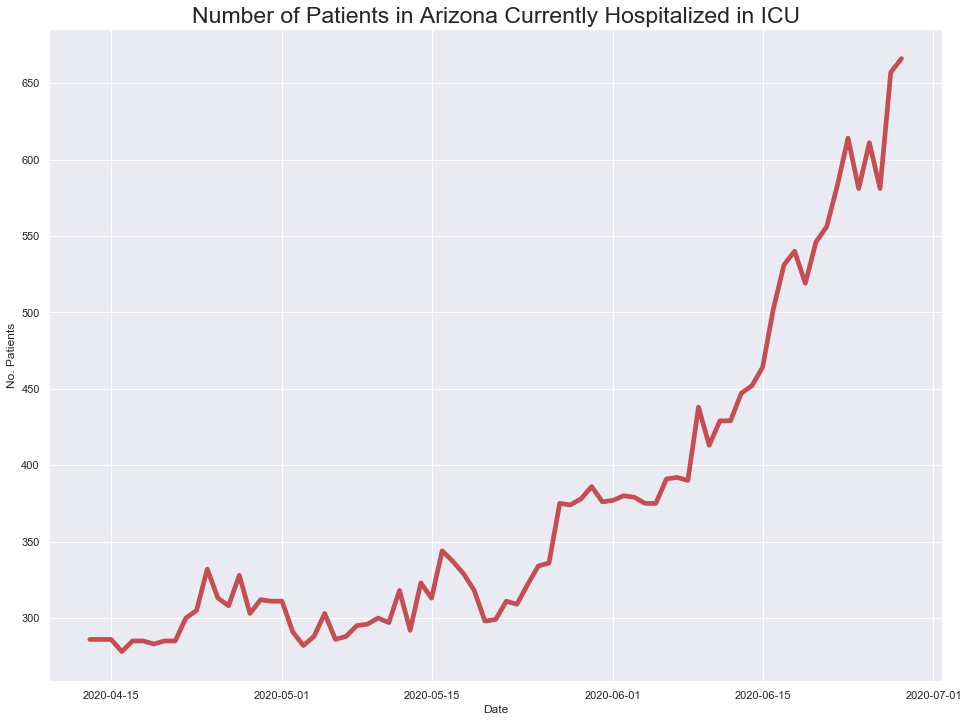

In [102]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(arizona.date, arizona.inIcuCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Arizona Currently Hospitalized in ICU', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

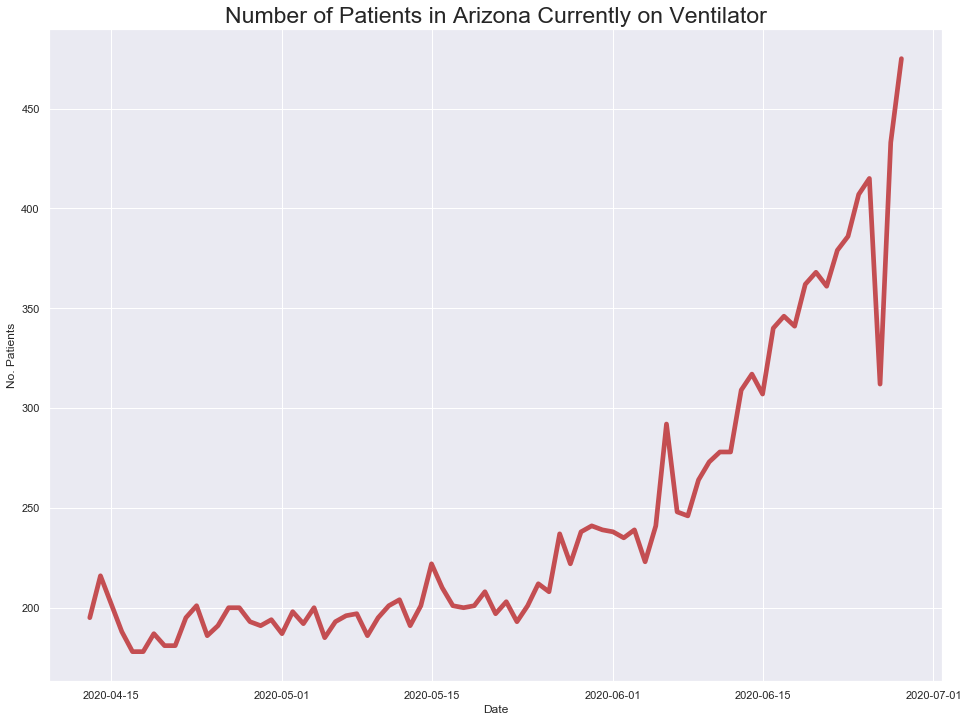

In [103]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(arizona.date, arizona.onVentilatorCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Arizona Currently on Ventilator', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [104]:
# Checking which cols have NaN values
arizona[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
arizona.head()

# Omit the NaN cols
arizona = arizona[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

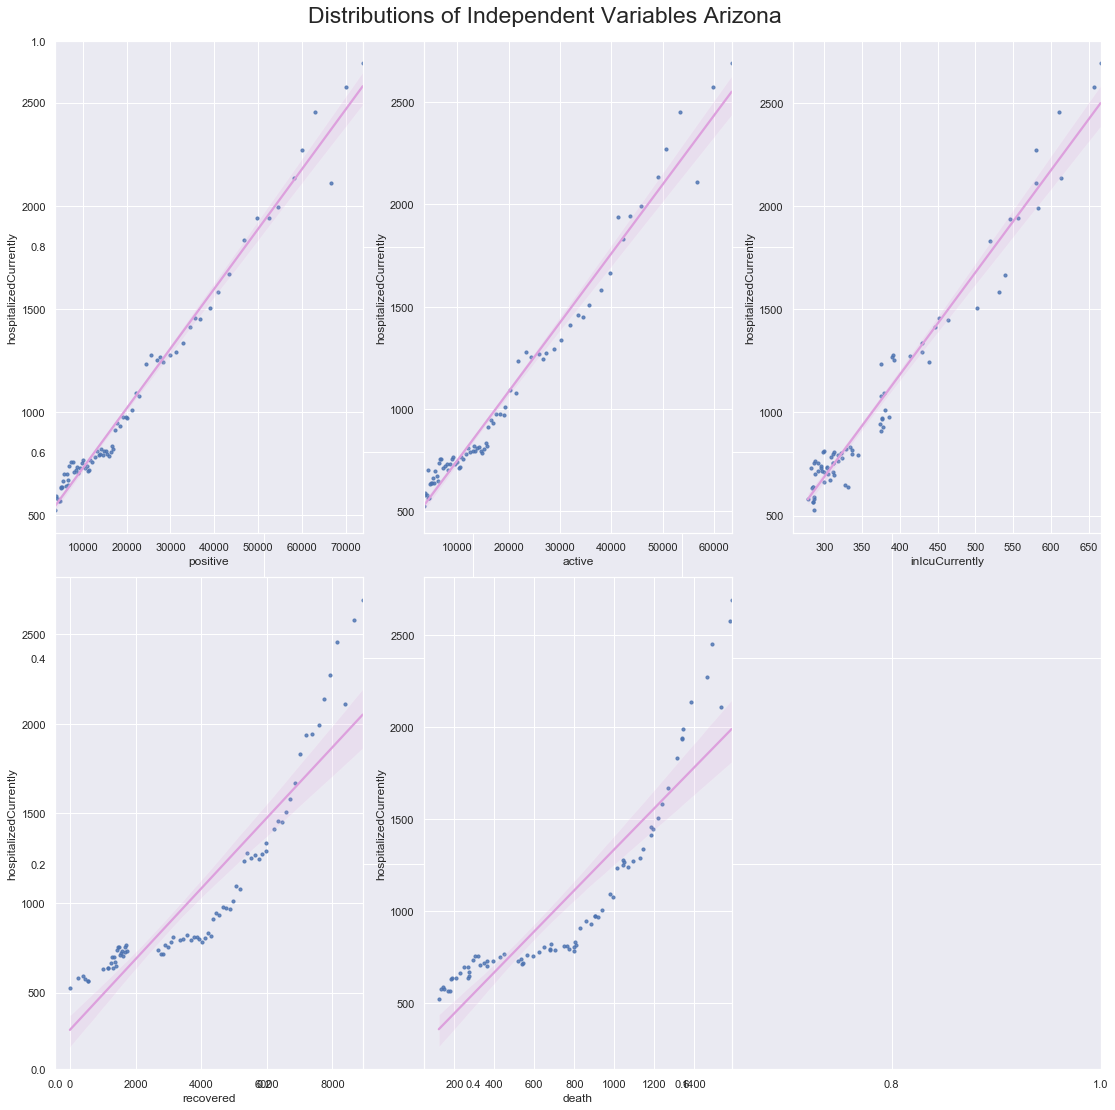

In [105]:
# Scatter plots AZ
# Split dependent var from independent variables
target_az = arizona.hospitalizedCurrently
indep_var_az = arizona.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_az.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_az[col], y=target_az, data=indep_var_az, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables Arizona', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

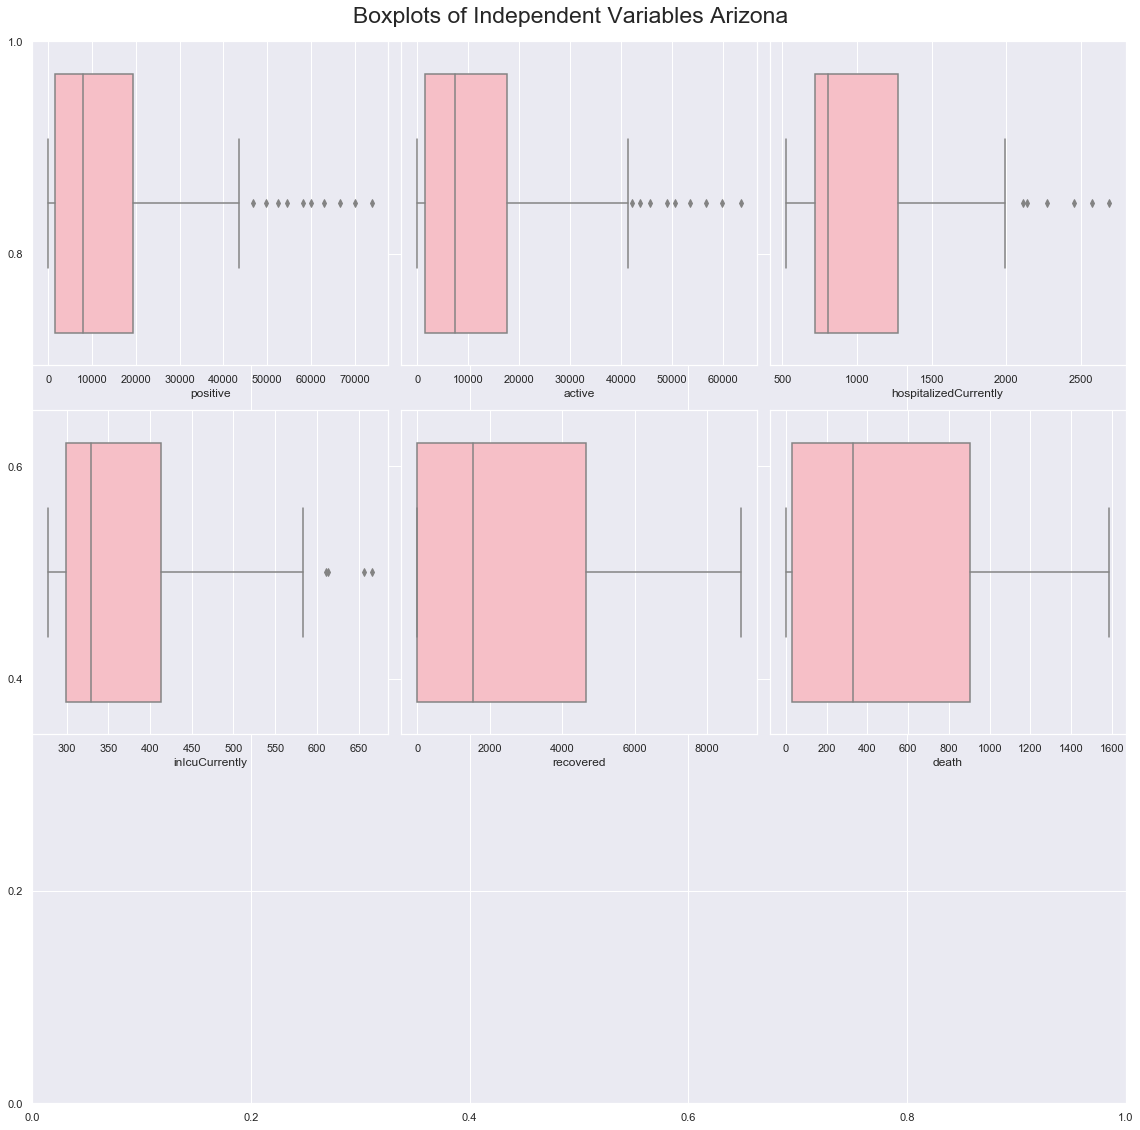

In [106]:
# Boxplot of AZ
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(arizona.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=arizona[col], data=arizona, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables Arizona', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [107]:
###endarizona

### Mississippi:

In [111]:
mississippi = covid_df.loc[(covid_df['abbrev'] == 'MS') & (covid_df['state']== 'Mississippi')] 


Text(0, 0.5, 'No. Patients')

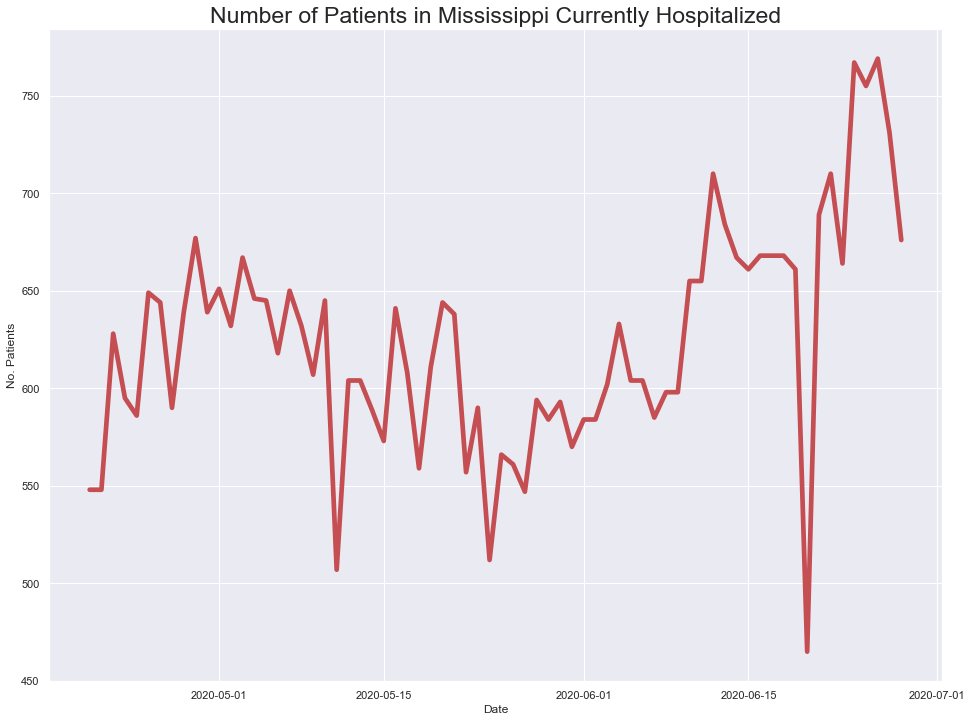

In [113]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(mississippi.date, mississippi.hospitalizedCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Mississippi Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

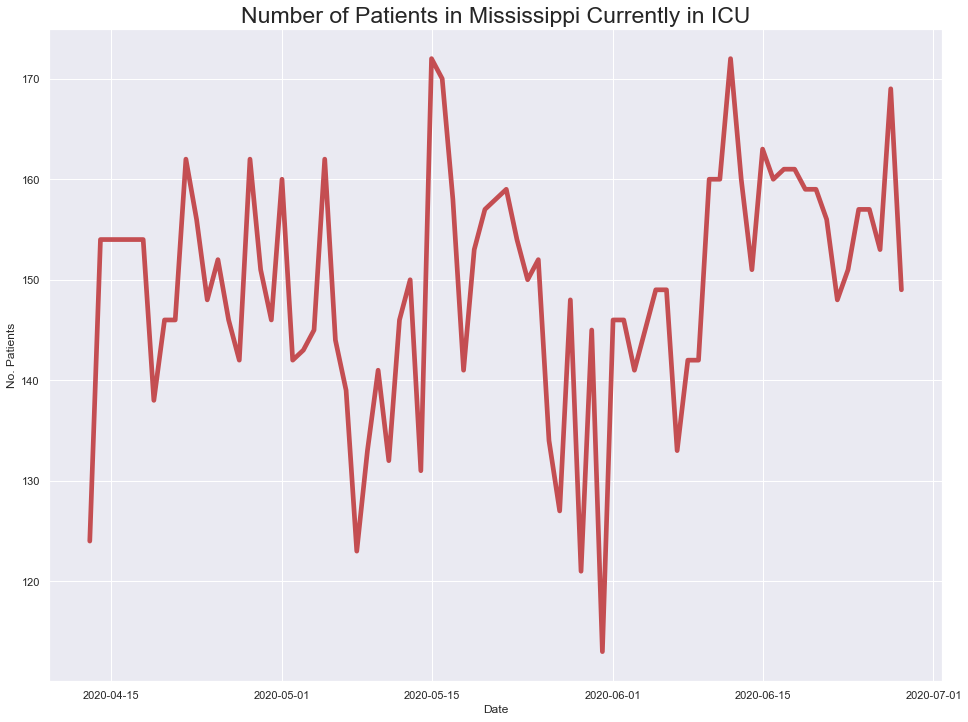

In [114]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(mississippi.date, mississippi.inIcuCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Mississippi Currently in ICU', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

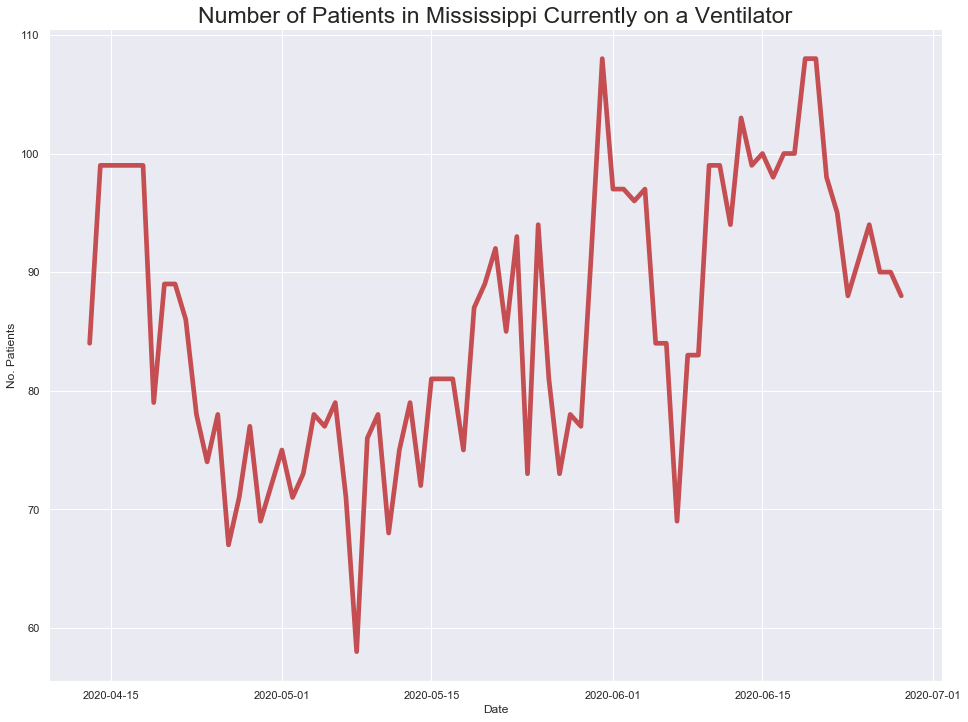

In [115]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(mississippi.date, mississippi.onVentilatorCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Mississippi Currently on a Ventilator', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

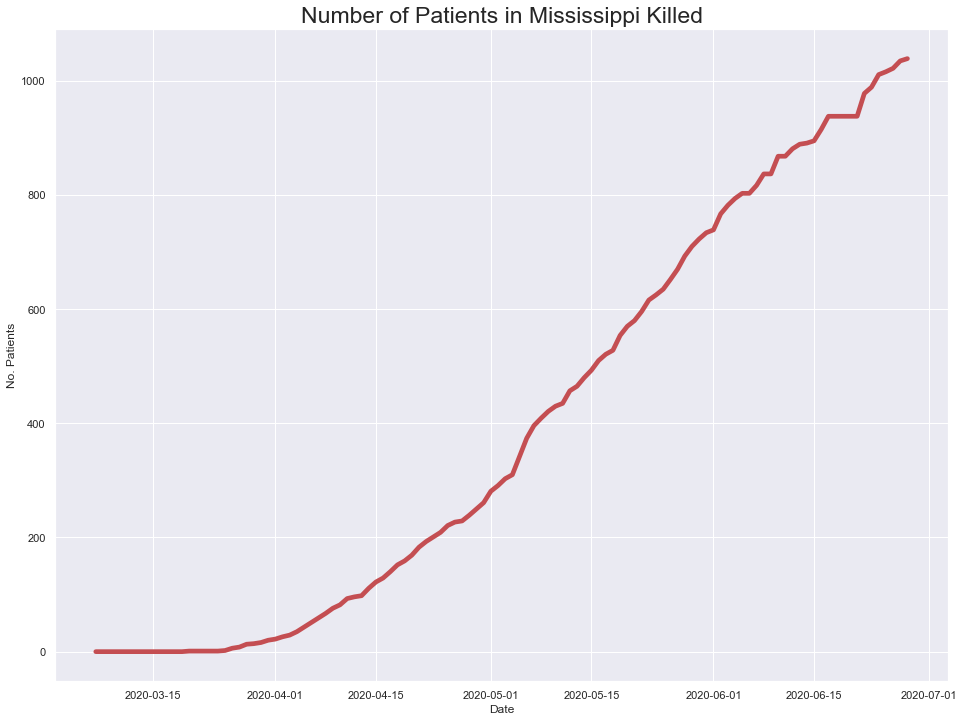

In [116]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(mississippi.date, mississippi.death, linewidth=4.7, color='r')
plt.title('Number of Patients in Mississippi Killed', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [117]:
# Checking which cols have NaN values
mississippi[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
mississippi.head()

# Omit the NaN cols
mississippi = mississippi[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

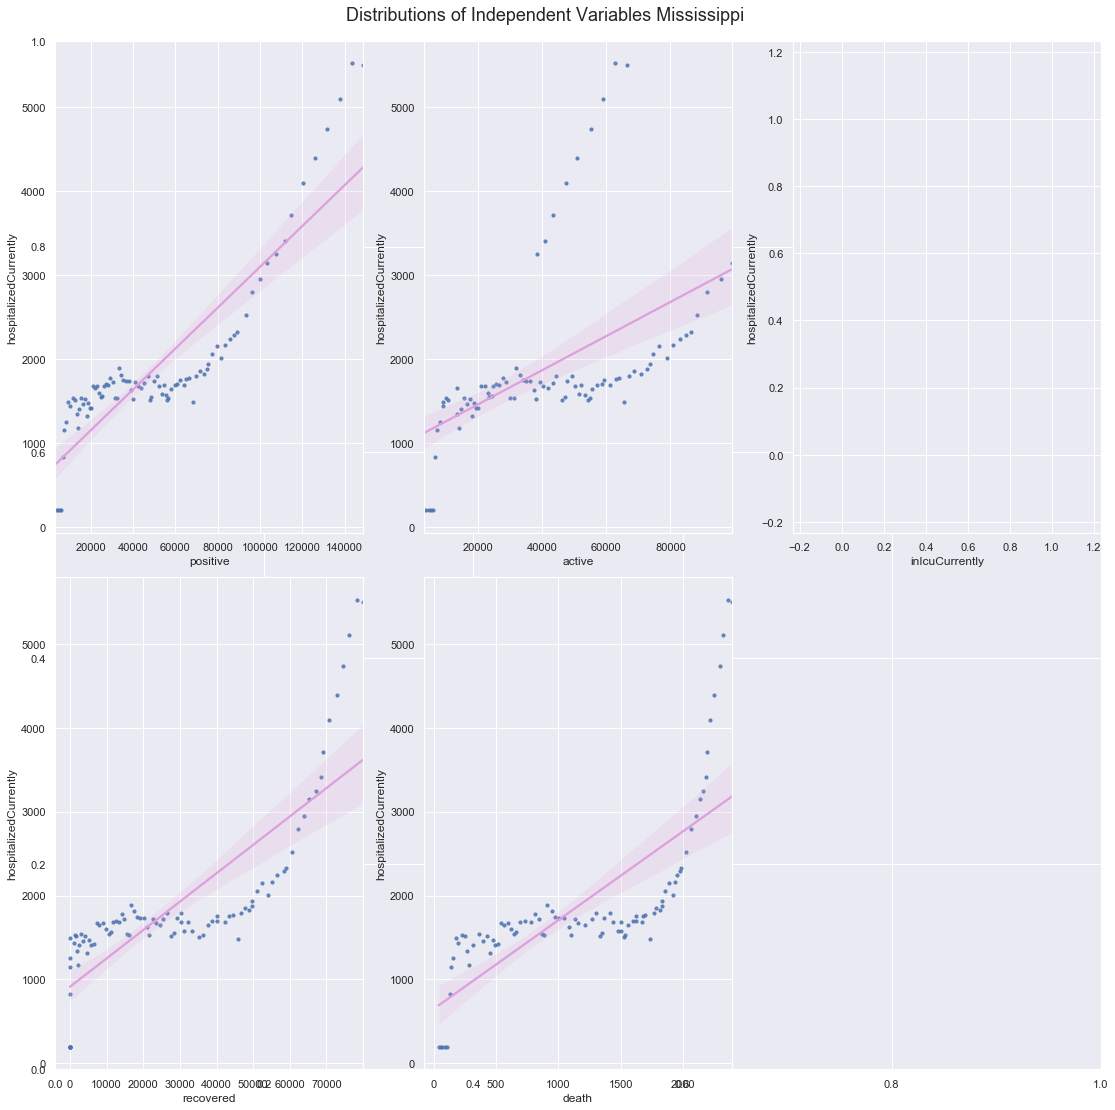

In [121]:
# Scatter plots MS
# Split dependent var from independent variables
target_ms = texas.hospitalizedCurrently
indep_var_ms = texas.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_ms.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_ms[col], y=target_ms, data=indep_var_ms, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables Mississippi', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

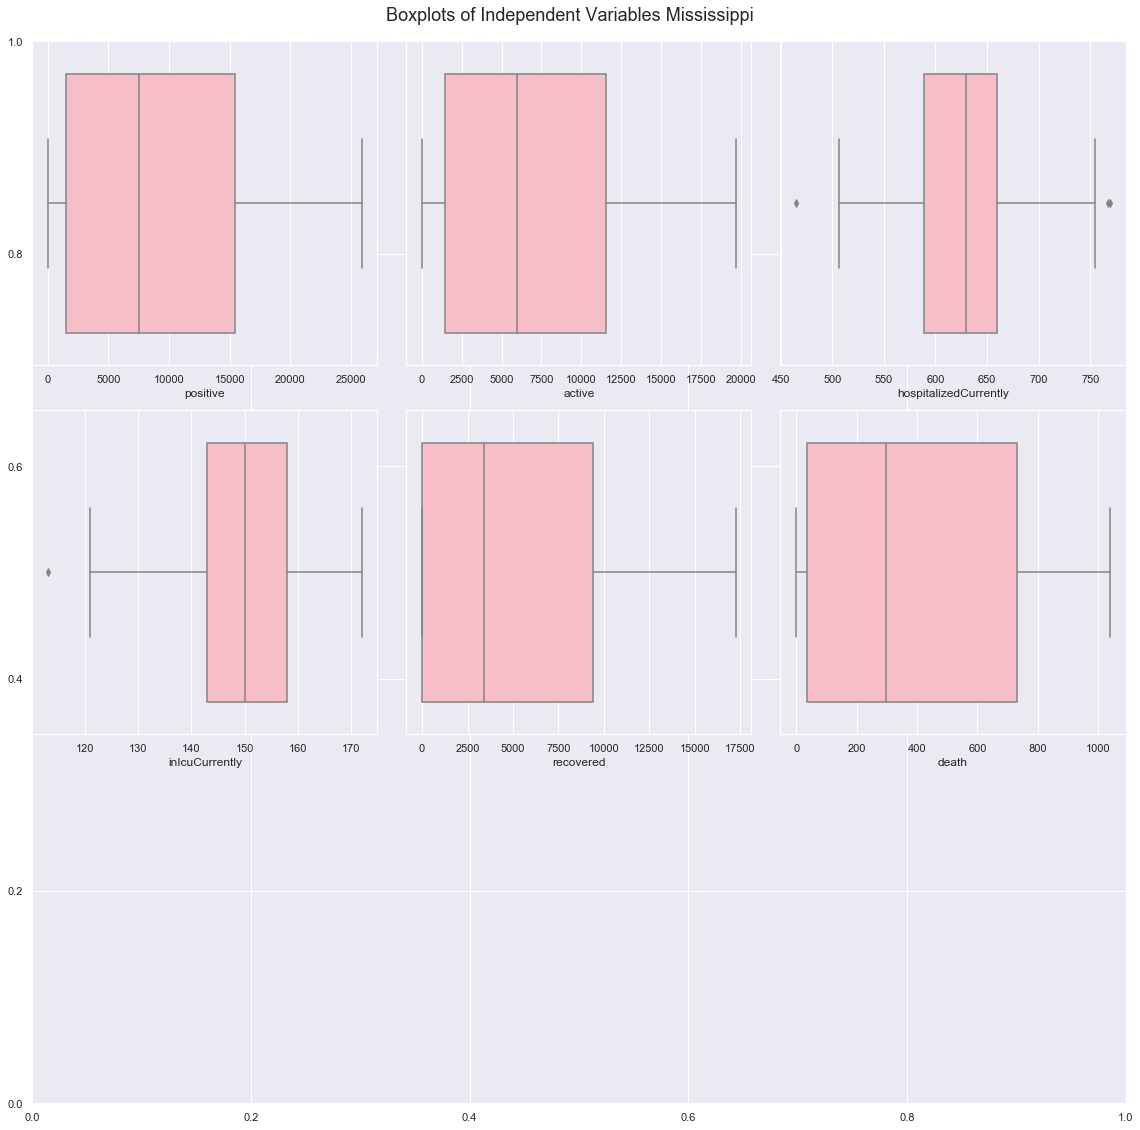

In [122]:
# Boxplot of MS
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(texas.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=mississippi[col], data=mississippi, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables Mississippi', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [120]:
###endmississippi

### Utah:

In [164]:
utah = covid_df.loc[(covid_df['abbrev'] == 'UT') & (covid_df['state']== 'Utah')] 


Text(0, 0.5, 'No. Patients')

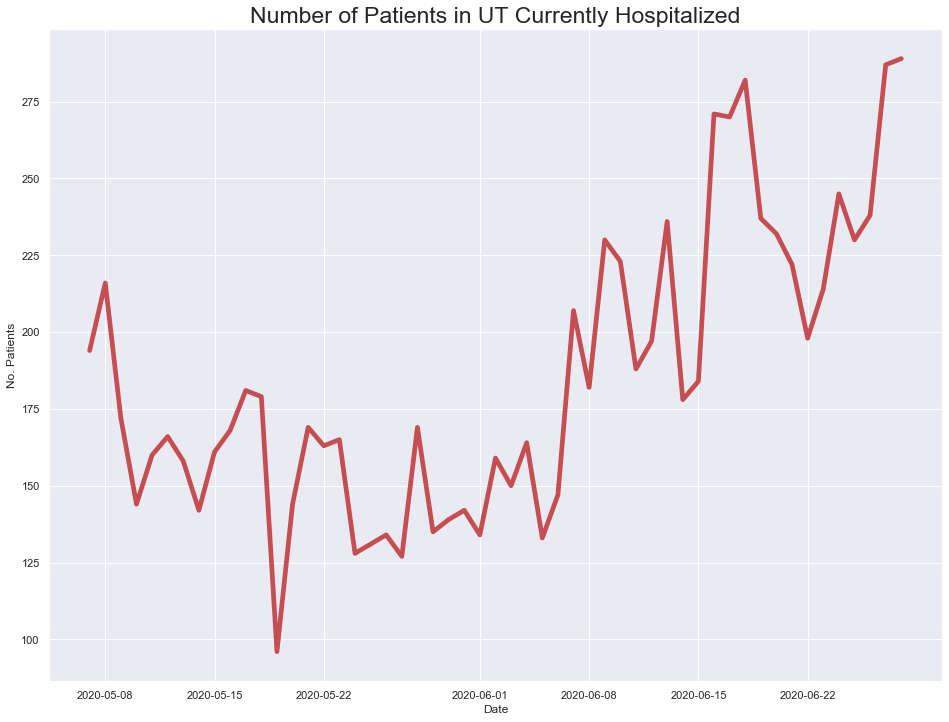

In [165]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(utah.date, utah.hospitalizedCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in UT Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

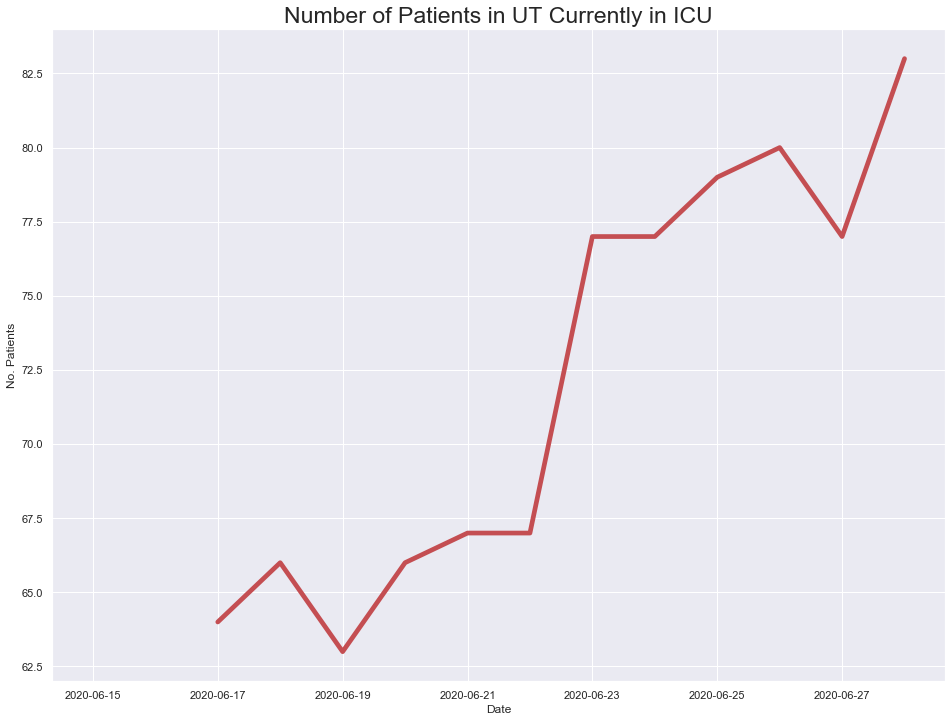

In [166]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(utah.date, utah.inIcuCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in UT Currently in ICU', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

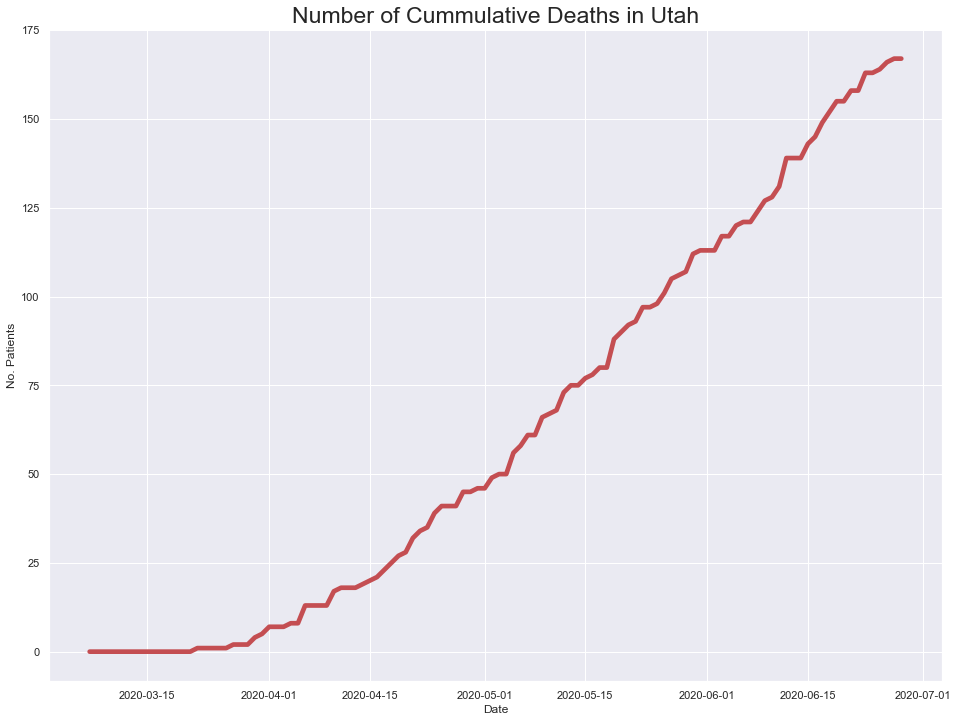

In [167]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(utah.date, utah.death, linewidth=4.7, color='r')
plt.title('Number of Cummulative Deaths in Utah', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [168]:
# Checking which cols have NaN values
utah[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
utah.head()

# Omit the NaN cols
utah = utah[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

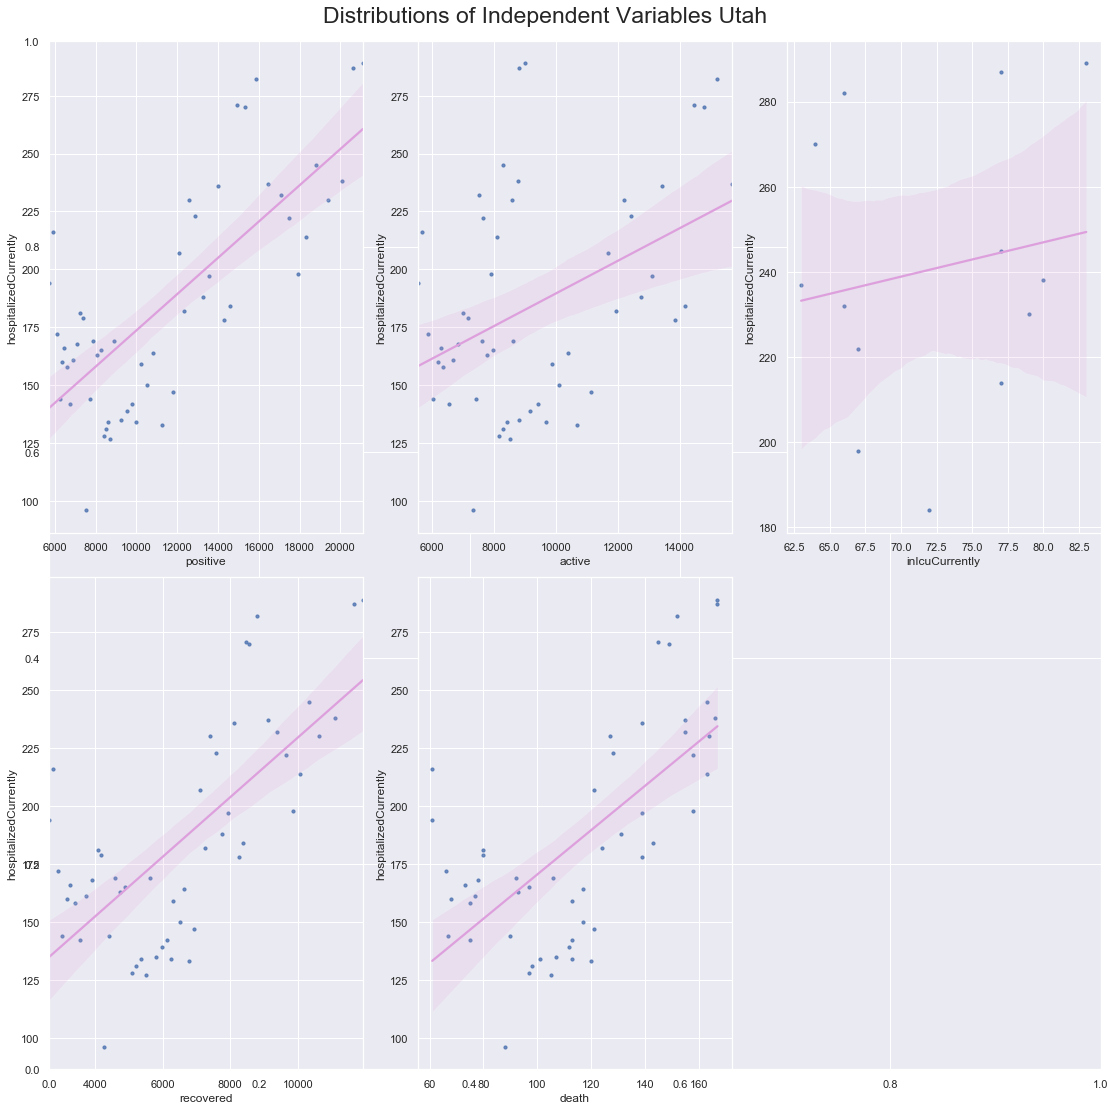

In [169]:
# Scatter plots UT
# Split dependent var from independent variables
target_ut = utah.hospitalizedCurrently
indep_var_ut = utah.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_tx.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_ut[col], y=target_ut, data=indep_var_ut, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables Utah', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [170]:
###endutah

### Georgia:

In [179]:
georgia = covid_df.loc[(covid_df['abbrev'] == 'GA') & (covid_df['state']== 'Georgia')] 


Text(0, 0.5, 'No. Patients')

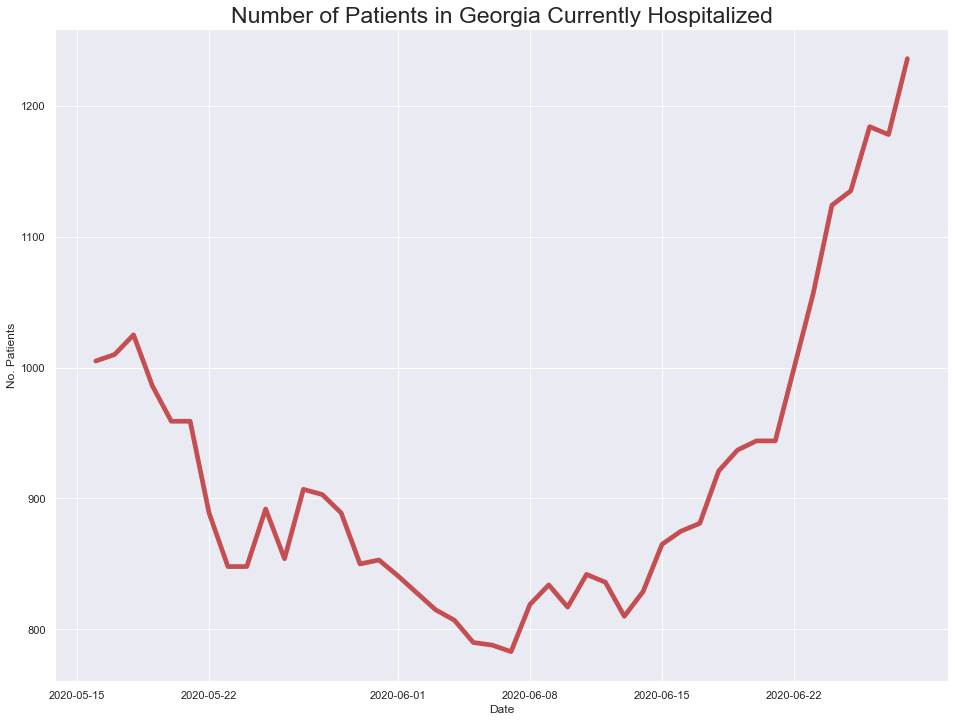

In [180]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(georgia.date, georgia.hospitalizedCurrently, linewidth=4.7, color='r')
plt.title('Number of Patients in Georgia Currently Hospitalized', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

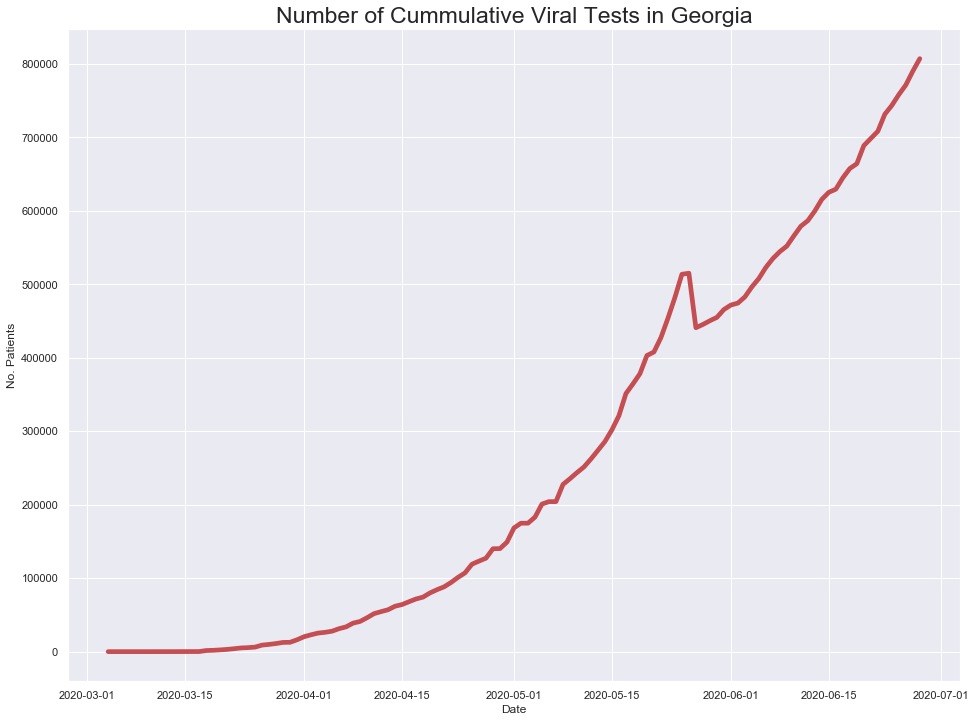

In [181]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(georgia.date, georgia.totalTestsViral, linewidth=4.7, color='r')
plt.title('Number of Cummulative Viral Tests in Georgia', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, 'No. Patients')

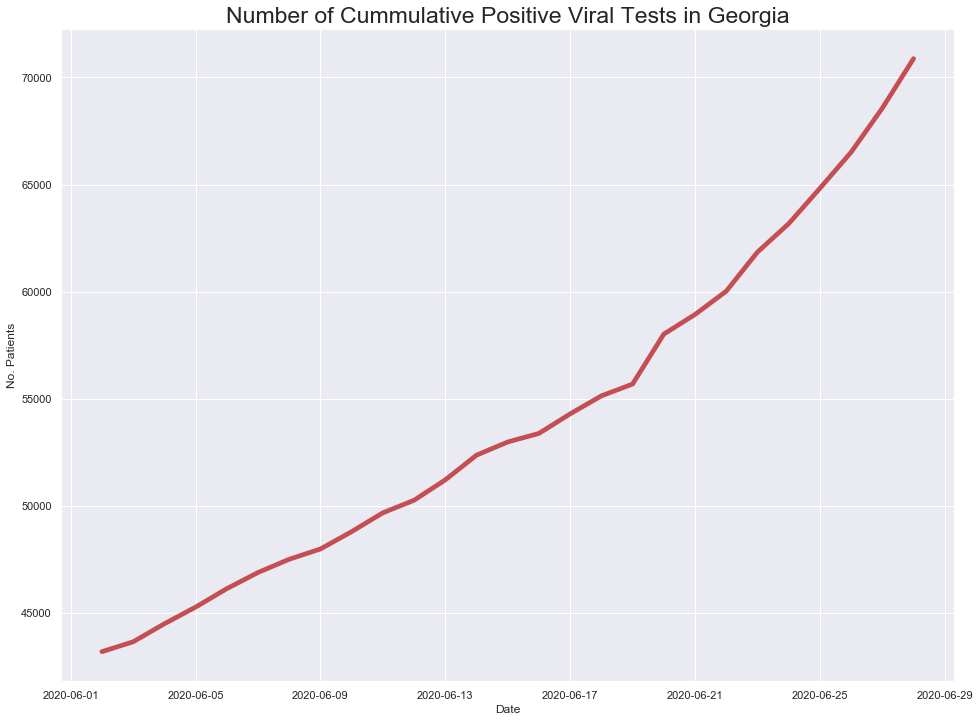

In [182]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(georgia.date, georgia.positiveTestsViral, linewidth=4.7, color='r')
plt.title('Number of Cummulative Positive Viral Tests in Georgia', fontsize=23)
plt.xlabel('Date')
plt.ylabel('No. Patients')

Text(0, 0.5, '% Infection Rate')

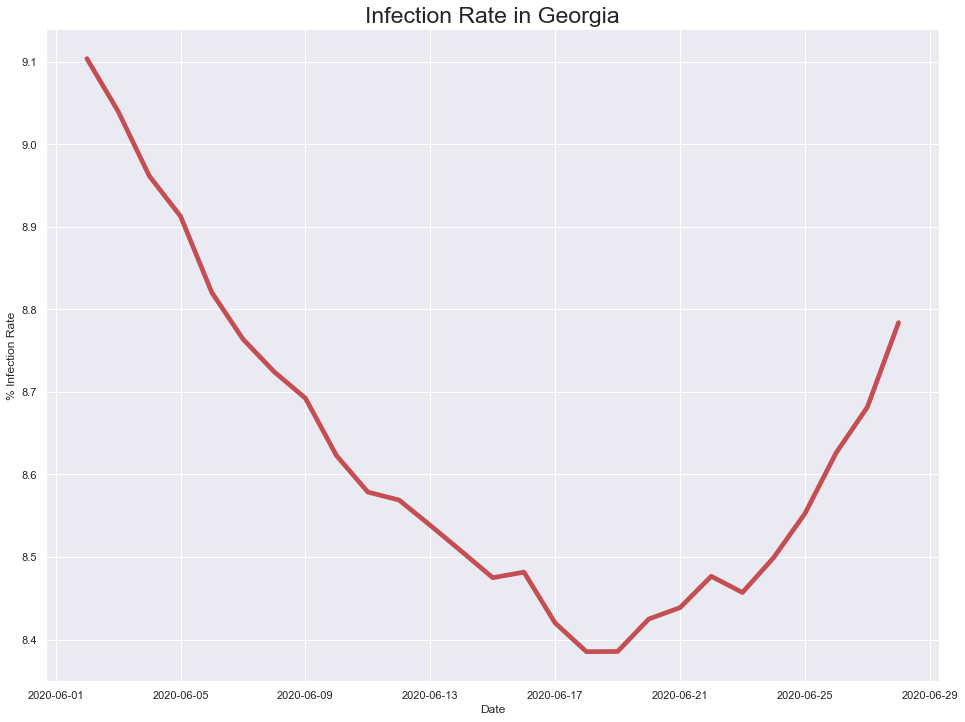

In [183]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(georgia.date, georgia.positiveTestsViral/georgia.totalTestsViral*100, linewidth=4.7, color='r')
plt.title('Infection Rate in Georgia', fontsize=23)
plt.xlabel('Date')
plt.ylabel('% Infection Rate')

In [184]:
# Checking which cols have NaN values
georgia[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
georgia.head()

# Omit the NaN cols
georgia = georgia[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

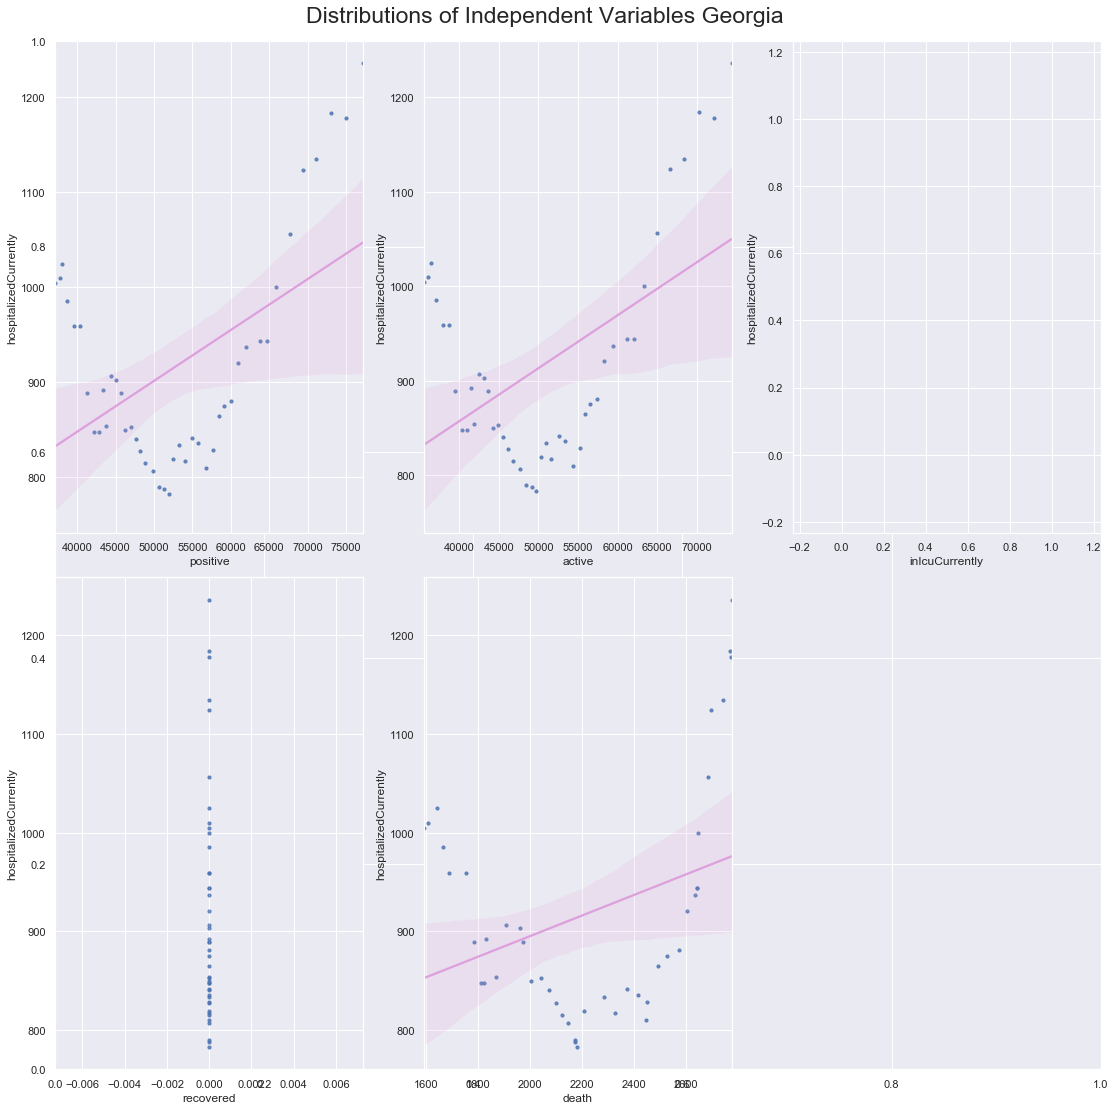

In [185]:
# Scatter plots GA
# Split dependent var from independent variables
target_ga = georgia.hospitalizedCurrently
indep_var_ga = georgia.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_ga.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_ga[col], y=target_ga, data=indep_var_ga, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables Georgia', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

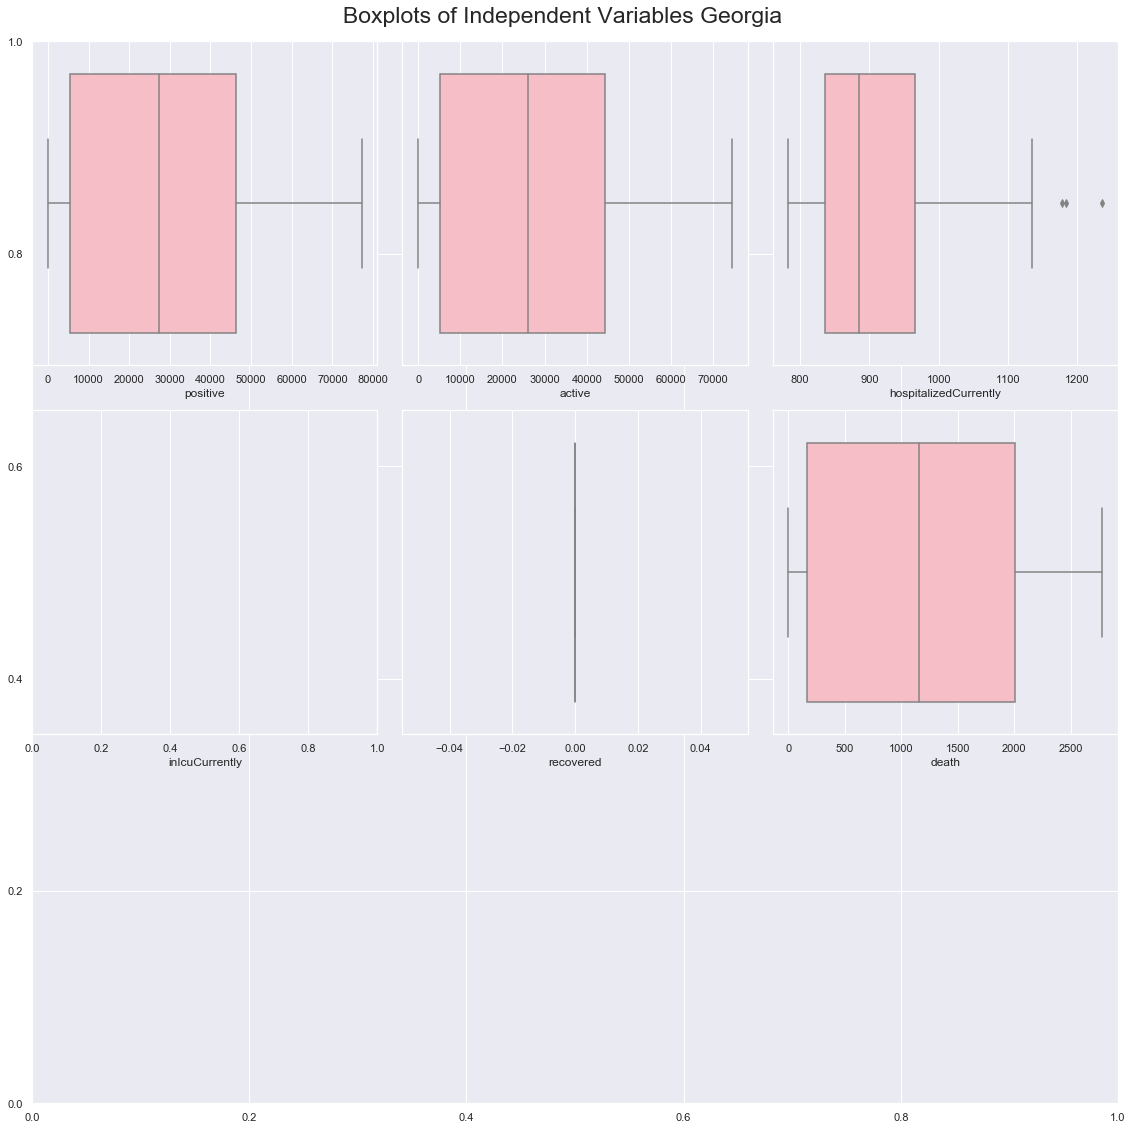

In [186]:
# Boxplot of GA
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(georgia.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=georgia[col], data=georgia, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables Georgia', fontsize=23)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [149]:
###endgeorgia

### Alabama:

In [ ]:
bama = covid_df.loc[(covid_df['abbrev'] == 'AL') & (covid_df['state']== 'Alabama')] 


In [ ]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(bama.date, bama.hospitalizedCurrently)
plt.title('Number of Patients in AL Currently Hospitalized')
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [ ]:
# Checking which cols have NaN values
bama[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
bama.head()

# Omit the NaN cols
bama = bama[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

In [ ]:
# Scatter plots AL
# Split dependent var from independent variables
target_al = bama.hospitalizedCurrently
indep_var_al = bama.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_al.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_al[col], y=target_al, data=indep_var_al, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables AL', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [ ]:
# Boxplot of AL
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(bama.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=bama[col], data=bama, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables TX', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [ ]:
###endalabama

### Oklahoma:

In [ ]:
oklahoma = covid_df.loc[(covid_df['abbrev'] == 'OK') & (covid_df['state']== 'Oklahoma')] 


In [ ]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
fig, ax = plt.subplots(figsize = (16, 12))
plt.plot(oklahoma.date, oklahoma.hospitalizedCurrently)
plt.title('Number of Patients in OK Currently Hospitalized')
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [ ]:
# Checking which cols have NaN values
oklahoma[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
oklahoma.head()

# Omit the NaN cols
oklahoma = oklahoma[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

In [ ]:
# Scatter plots OK
# Split dependent var from independent variables
target_ok = oklahoma.hospitalizedCurrently
indep_var_ok = oklahoma.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(indep_var_ok.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_ok[col], y=target_ok, data=indep_var_ok, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables OK', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [ ]:
# Boxplot of OK
fig, ax = plt.subplots(figsize = (16, 16))
for i, col in enumerate(oklahoma.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=oklahoma[col], data=oklahoma, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables OK', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

In [ ]:
###endoklahoma

## Assessing Correlation of Independent Variables

In [ ]:
# TODO add some explanation / look more into collinear variables

In [ ]:
# Heatmap of correlations
# Save correlations to variable
corr = covid_cleaned.corr(method='pearson')
# We can create a mask to not show duplicate values
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(16,16))

# Generate heatmap
sns.heatmap(corr, annot=True, mask=mask, cmap='GnBu', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Build model for dependent Variable 
- To be used to predict current hospitalizations
- Having more complete variables for in ICU currently and on Ventilator Currently will allow us to predict these numbers as well.

In [ ]:
# We compare three models:
# - Polynomial Regression
# - Linear Regression
# - ElasticNet

# Copy DFs to not mess up original one
# We will use model_df for our regression model
model_df = all_cases.copy()

# Delete redundant rows
for row in ['abbrev', 'bedsPerThousand', 'hospitalized', 
'state', 'hospitalizedCumulative', 'dataQualityGrade', 'lastUpdateEt']:
    del model_df[row]

# Drop NaN values for hospitalizedCurrently
model_df = model_df.dropna(subset=['hospitalizedCurrently'])

# Drop Values with abnormal active-hospitalised ratios (outside Conf. Interval)
model_df['ratio_hospital'] = model_df['hospitalizedCurrently'] / model_df['active']
model_df = model_df[~(model_df['ratio_hospital'] >= model_df.ratio_hospital.quantile(0.99))]

#model_df = model_df[~(model_df['ratio_hospital'] <= model_df['ratio_hospital'].median())]
del model_df['ratio_hospital']

# Get peek of model to use
model_df.describe()

In [ ]:
### Mark Bee (https://www.facebook.com/markbeenyc) - do you need a sippy cup lesson on this information?   